# HCP1200 DTI Exploratory Data Analysis

## Setup 

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-02-24 20:24:00.807824: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 20:24:03.585464: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-24 20:24:05.911069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from sim import *

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome


### Paths and metadata

In [4]:
# Set paths
GeneEx2Conn_path = os.path.normpath(os.getcwd())
HCP1200_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/HCP1200_DTI/' #HCP_YA1065_FIB_2mm/'
print(GeneEx2Conn_path)
print(HCP1200_path)

schaef156_atlas_path = HCP1200_path + '/4S156/atlas-4S156Parcels_dseg.tsv'
schaef156_atlas_info = pd.read_csv(schaef156_atlas_path, sep='\t')
schaef156_labels = schaef156_atlas_info['label'].tolist()

schaef156_atlas_info.loc[schaef156_atlas_info['atlas_name'] == 'Cerebellum', 'network_label'] = 'Cerebellum'
schaef156_atlas_info.loc[(schaef156_atlas_info['network_label'].isna()) & 
                        (schaef156_atlas_info['atlas_name'] != 'Cerebellum'), 'network_label'] = 'Subcortical'

schaef156_labels = schaef156_atlas_info['label'].tolist()
schaef156_network_labels = schaef156_atlas_info['network_label'].values

schaef456_atlas_path = HCP1200_path + '/4S456/atlas-4S456Parcels_dseg.tsv'
schaef456_atlas_info = pd.read_csv(schaef456_atlas_path, sep='\t')
schaef456_labels = schaef456_atlas_info['label'].tolist()

schaef456_atlas_info.loc[schaef456_atlas_info['atlas_name'] == 'Cerebellum', 'network_label'] = 'Cerebellum'
schaef456_atlas_info.loc[(schaef456_atlas_info['network_label'].isna()) & 
                        (schaef456_atlas_info['atlas_name'] != 'Cerebellum'), 'network_label'] = 'Subcortical'

schaef456_labels = schaef456_atlas_info['label'].tolist()
schaef456_network_labels = schaef456_atlas_info['network_label'].values

subjects_all = [d for d in os.listdir(HCP1200_path + '/HCP_YA1065_FIB_2mm/') if os.path.isdir(os.path.join(HCP1200_path + '/HCP_YA1065_FIB_2mm/', d))]

/scratch/asr655/neuroinformatics/GeneEx2Conn
/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_DTI/


## Load data

### Load all subjects and generate population average connectomes

In [5]:
HCP1200_path + '/HCP_YA1065_FIB_2mm/100206/100206.src.gz.gqi.1.7.fib.gz.tt.gz.atlas-4S456Parcels_space-MNI152NLin6Asym_dseg.count.pass.connectivity.mat'
matrix = np.log1p(loadmat('./data/HCP1200/4S456_DTI_count.mat')['connectivity'])


In [6]:
def compute_HCP_population_average_connectome(subject_list, data_path, atlas_name='456', verbose=True):
    """
    Compute population average connectome from a list of subjects.
    
    Parameters
    ----------
    subject_list : list
        List of subject IDs
    data_path : str
        Path to data directory
    atlas_name : str, optional
        Atlas to use ('156' or '456'), by default '456'
    verbose : bool, optional
        Whether to print progress, by default True
        
    Returns
    -------
    tuple
        (population average connectome matrix,
         list of individual subject connectomes)
    """
    # Validate atlas name
    atlas_str = '4S156Parcels' if atlas_name == '156' else '4S456Parcels' if atlas_name == '456' else None
    if not atlas_str:
        raise ValueError(f"Unsupported atlas_name: {atlas_name}")

    # Initialize list to store connectomes
    connectomes = []
    n_skipped = 0

    # Collect all valid connectomes
    for i, subject_id in enumerate(subject_list):
        if verbose and i % 100 == 0:
            print(f"Loading subject {i}/{len(subject_list)}")
            
        # Construct path to subject's connectivity matrix
        if atlas_name == '456':
            conn_path = os.path.join(data_path, 'HCP_YA1065_FIB_2mm', str(subject_id),
                f'{subject_id}.src.gz.gqi.1.7.fib.gz.tt.gz.atlas-{atlas_str}_space-MNI152NLin6Asym_dseg.count.pass.connectivity.mat')
        else:
            conn_path = os.path.join(data_path, 'HCP_YA1065_FIB_2mm', str(subject_id),
                f'{subject_id}.src.gz.gqi.1.7.tt.gz.atlas-{atlas_str}_space-MNI152NLin6Asym_dseg.count.pass.connectivity.mat')
        
        try:
            # Load and process connectome
            curr_mat = loadmat(conn_path)['connectivity']
            curr_mat = np.log1p(curr_mat) # Apply log1p transform
            connectomes.append(curr_mat)
        except Exception as e:
            if verbose:
                print(f"Error processing subject {subject_id}: {str(e)}")
            n_skipped += 1
            continue

    if verbose:
        print(f"Processed {len(connectomes)} subjects, skipped {n_skipped}")

    # Compute average
    pop_avg = np.nanmean(connectomes, axis=0)
    
    return pop_avg, connectomes

In [7]:
HCP1200_S156_connectome_mu, S156_connectomes = compute_HCP_population_average_connectome(
    subject_list=subjects_all,
    atlas_name='156',
    data_path=HCP1200_path
)

Loading subject 0/1065
Loading subject 100/1065
Loading subject 200/1065
Loading subject 300/1065
Loading subject 400/1065
Loading subject 500/1065
Loading subject 600/1065
Loading subject 700/1065
Loading subject 800/1065
Loading subject 900/1065
Loading subject 1000/1065
Processed 1065 subjects, skipped 0


In [8]:
HCP1200_S456_connectome_mu, S456_connectomes = compute_HCP_population_average_connectome(
    subject_list=subjects_all,
    atlas_name='456',
    data_path=HCP1200_path
)

Loading subject 0/1065
Loading subject 100/1065
Loading subject 200/1065
Loading subject 300/1065
Loading subject 400/1065
Loading subject 500/1065
Loading subject 600/1065
Loading subject 700/1065
Loading subject 800/1065
Loading subject 900/1065
Loading subject 1000/1065
Processed 1065 subjects, skipped 0


### Plot random connectomes

In [9]:
def plot_random_connectomes(connectomes, n_rows, max_rois):
    """
    Plot a grid of random connectomes from the dataset.
    
    Args:
        connectomes: List of connectome matrices
        n_rows: Number of rows/columns in the grid (total plots will be n_rows^2)
        max_rois: Maximum number of ROIs to show in each connectome plot
    """
    # Create a figure with n_rows x n_rows subplots
    fig, axes = plt.subplots(n_rows, n_rows, figsize=(2*n_rows, 2*n_rows))
    
    # Convert list to numpy array and get random indices
    connectome_array = np.array(connectomes)
    n_plots = n_rows * n_rows
    random_indices = np.random.choice(len(connectome_array), size=n_plots, replace=False)
    
    # Plot each connectome in the grid
    for idx, ax in enumerate(axes.flat):
        # Get random connectome and plot first max_rois x max_rois portion
        connectome = connectome_array[random_indices[idx]][:max_rois, :max_rois]
        im = ax.imshow(connectome, cmap='viridis')
        ax.axis('off')  # Turn off axis labels
    
    # Add a colorbar that applies to all subplots
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    plt.suptitle(f'{n_plots} Random UKBB Cortical Connectomes (rsFC)', y=0.92)
    plt.show()

In [10]:
def plot_connectome_with_networks(connectome_mu, network_labels=None, n_rois=None, title=None):
    """
    Plot a connectome matrix with optional network labels and size limit.
    
    Args:
        connectome_mu: Average connectome matrix to plot
        network_labels: Optional list of network labels for each ROI
        n_rois: Optional number of ROIs to display (will show first n_rois x n_rois portion)
        title: Optional title for the plot. If None, uses default title.
    """
    plt.figure(figsize=(12, 10), dpi=200)
    
    # Limit connectome size if specified
    if n_rois is not None:
        connectome_mu = connectome_mu[:n_rois, :n_rois]
        if network_labels is not None:
            network_labels = network_labels[:n_rois]
    
    # Create the heatmap
    im = plt.imshow(connectome_mu, cmap='viridis')
    plt.colorbar()

    if network_labels is not None:
        # Draw lines between different adjacent labels
        prev_label = network_labels[0]
        for i in range(1, len(network_labels)):
            if network_labels[i] != prev_label:
                plt.axhline(y=i-0.5, color='black', linewidth=0.5)
                plt.axvline(x=i-0.5, color='black', linewidth=0.5)
                prev_label = network_labels[i]
        
        # Create tick positions and labels
        tick_positions = []
        tick_labels = []
        start_idx = 0
        prev_label = network_labels[0]
        
        for i in range(1, len(network_labels)):
            if network_labels[i] != prev_label:
                tick_positions.append((start_idx + i - 1) / 2)
                tick_labels.append(prev_label)
                start_idx = i
                prev_label = network_labels[i]
        
        # Add the last group
        tick_positions.append((start_idx + len(network_labels) - 1) / 2)
        tick_labels.append(prev_label)

        plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
        plt.yticks(tick_positions, tick_labels)

    else:
        # Add numerical ticks every 20 ROIs (or 10 if total ROIs <= 100)
        total_rois = connectome_mu.shape[0]
        tick_interval = 20 if total_rois <= 200 else 50
        tick_positions = np.arange(0, total_rois, tick_interval)
        plt.xticks(tick_positions, tick_positions)
        plt.yticks(tick_positions, tick_positions)

    if title is None:
        title = 'Average Cortical Connectome (rsFC)'
    plt.title(title)
    plt.tight_layout()
    plt.show()


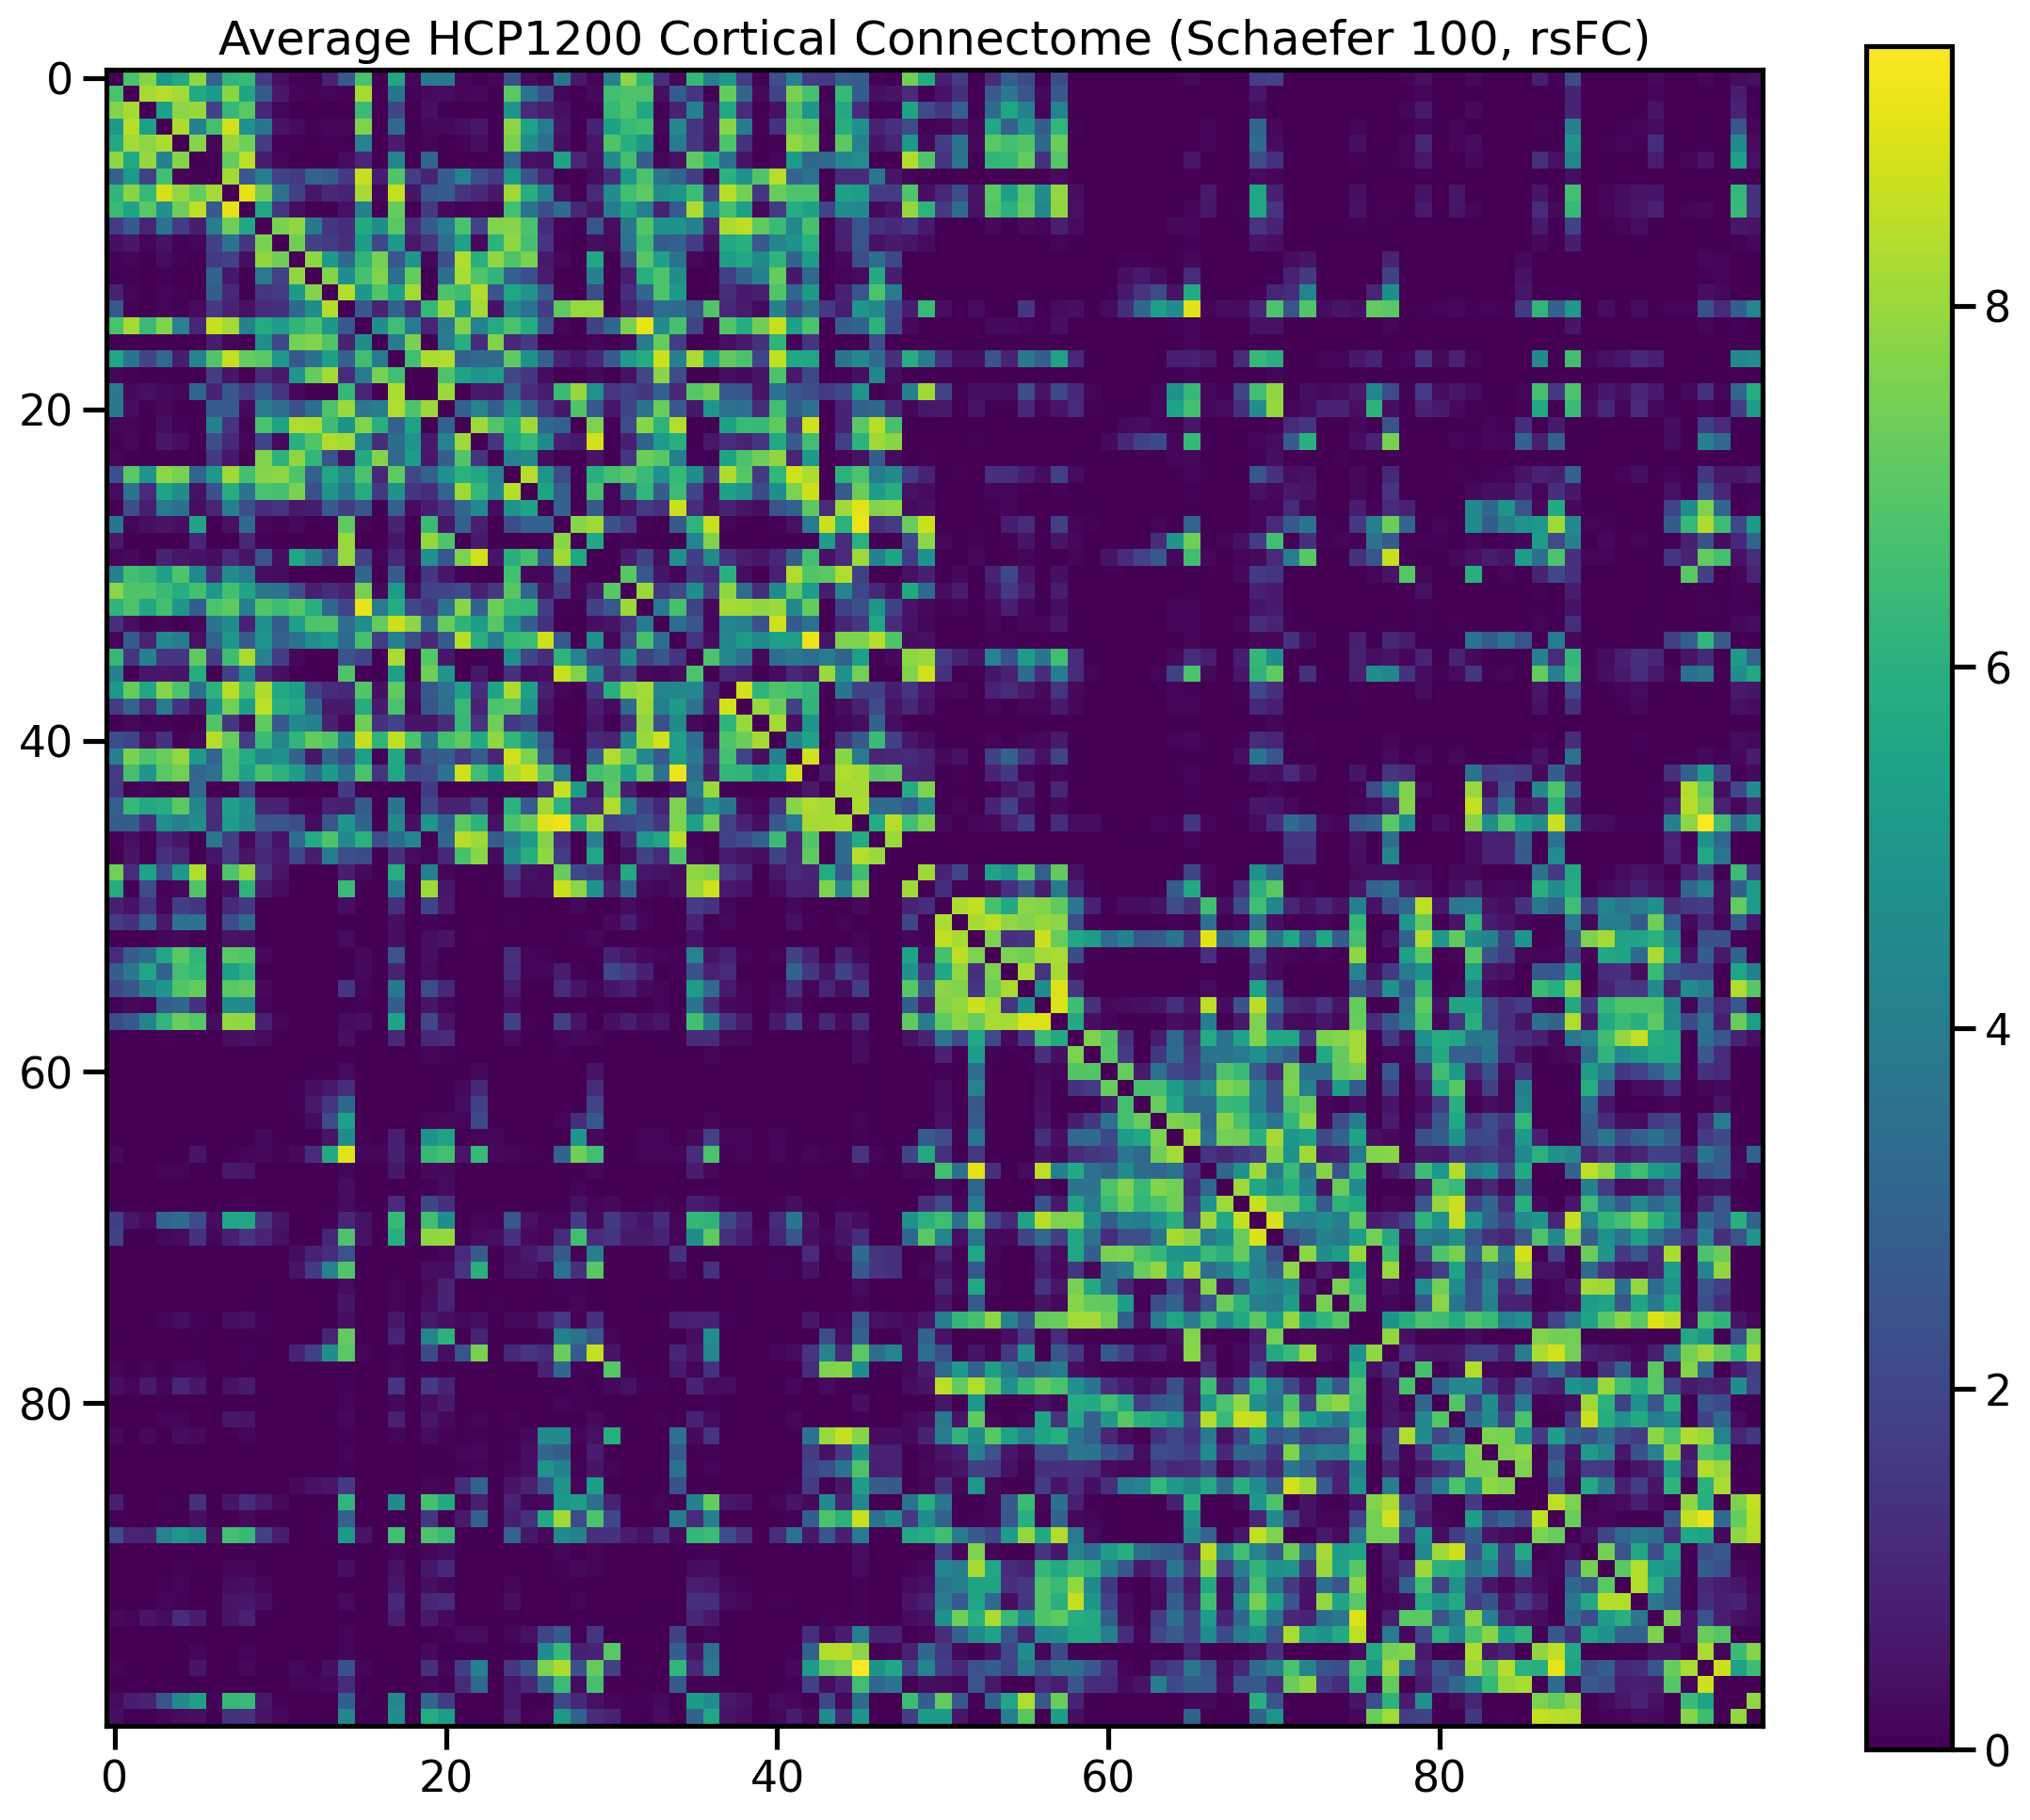

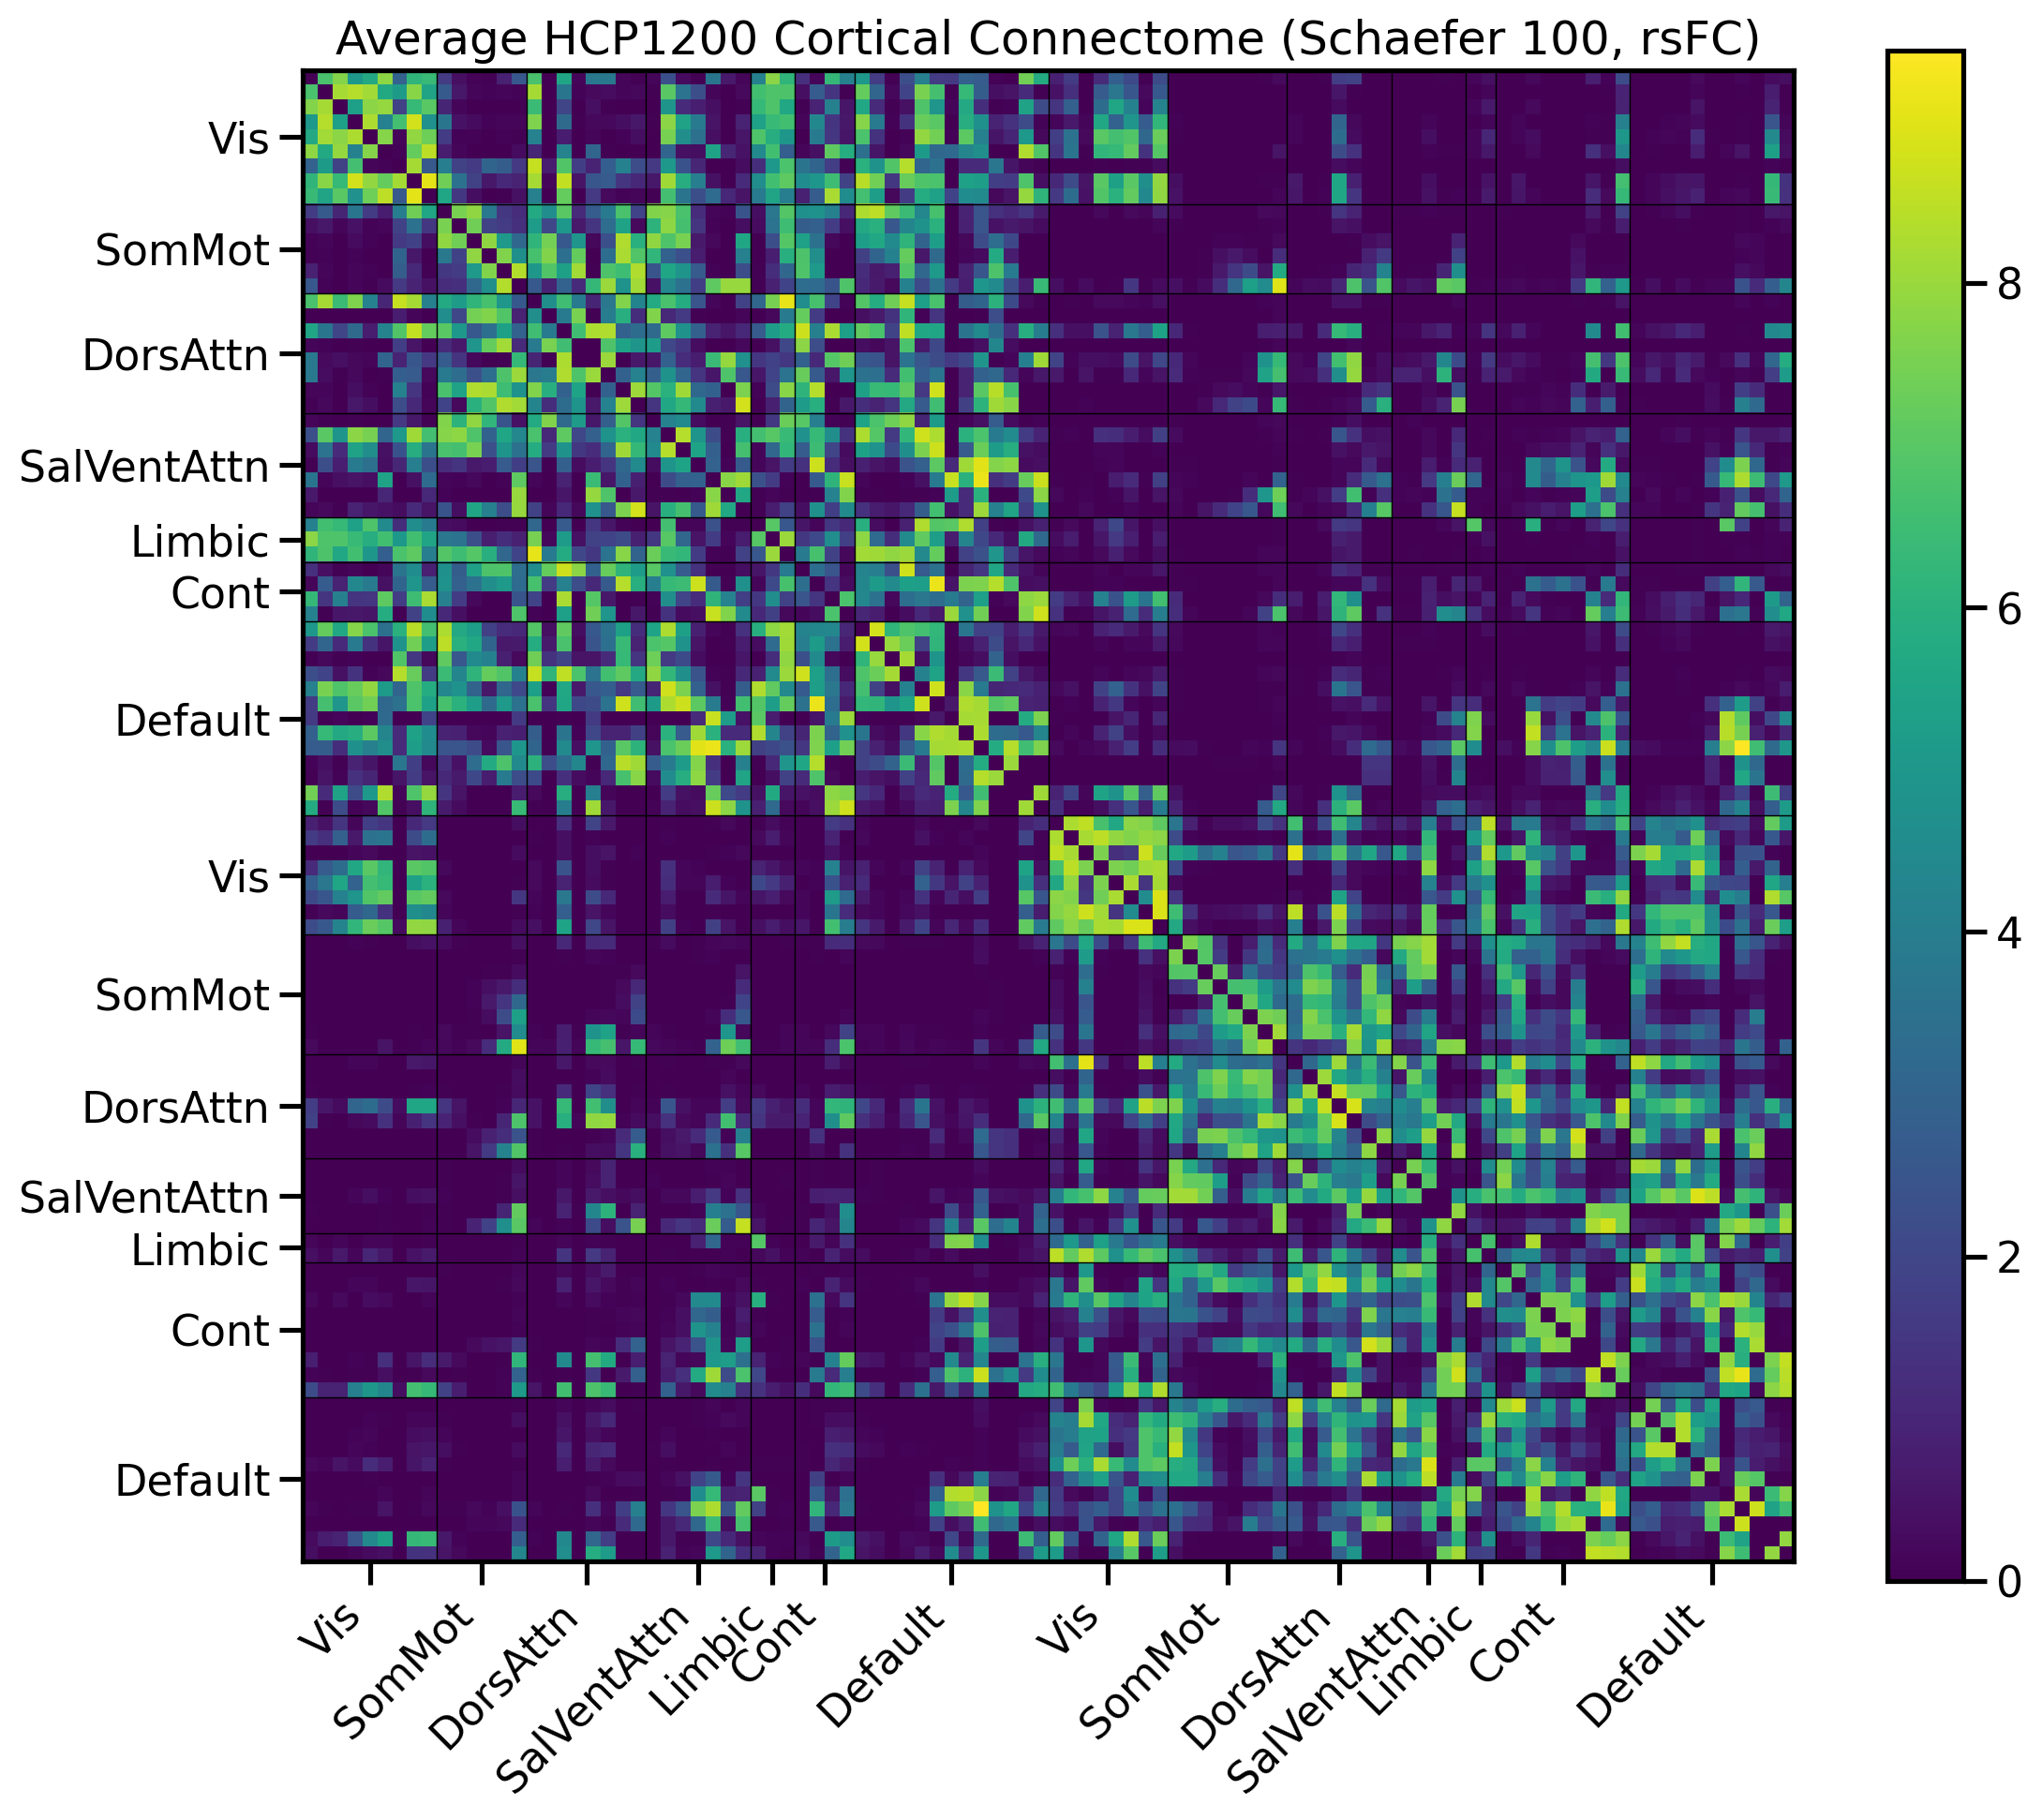

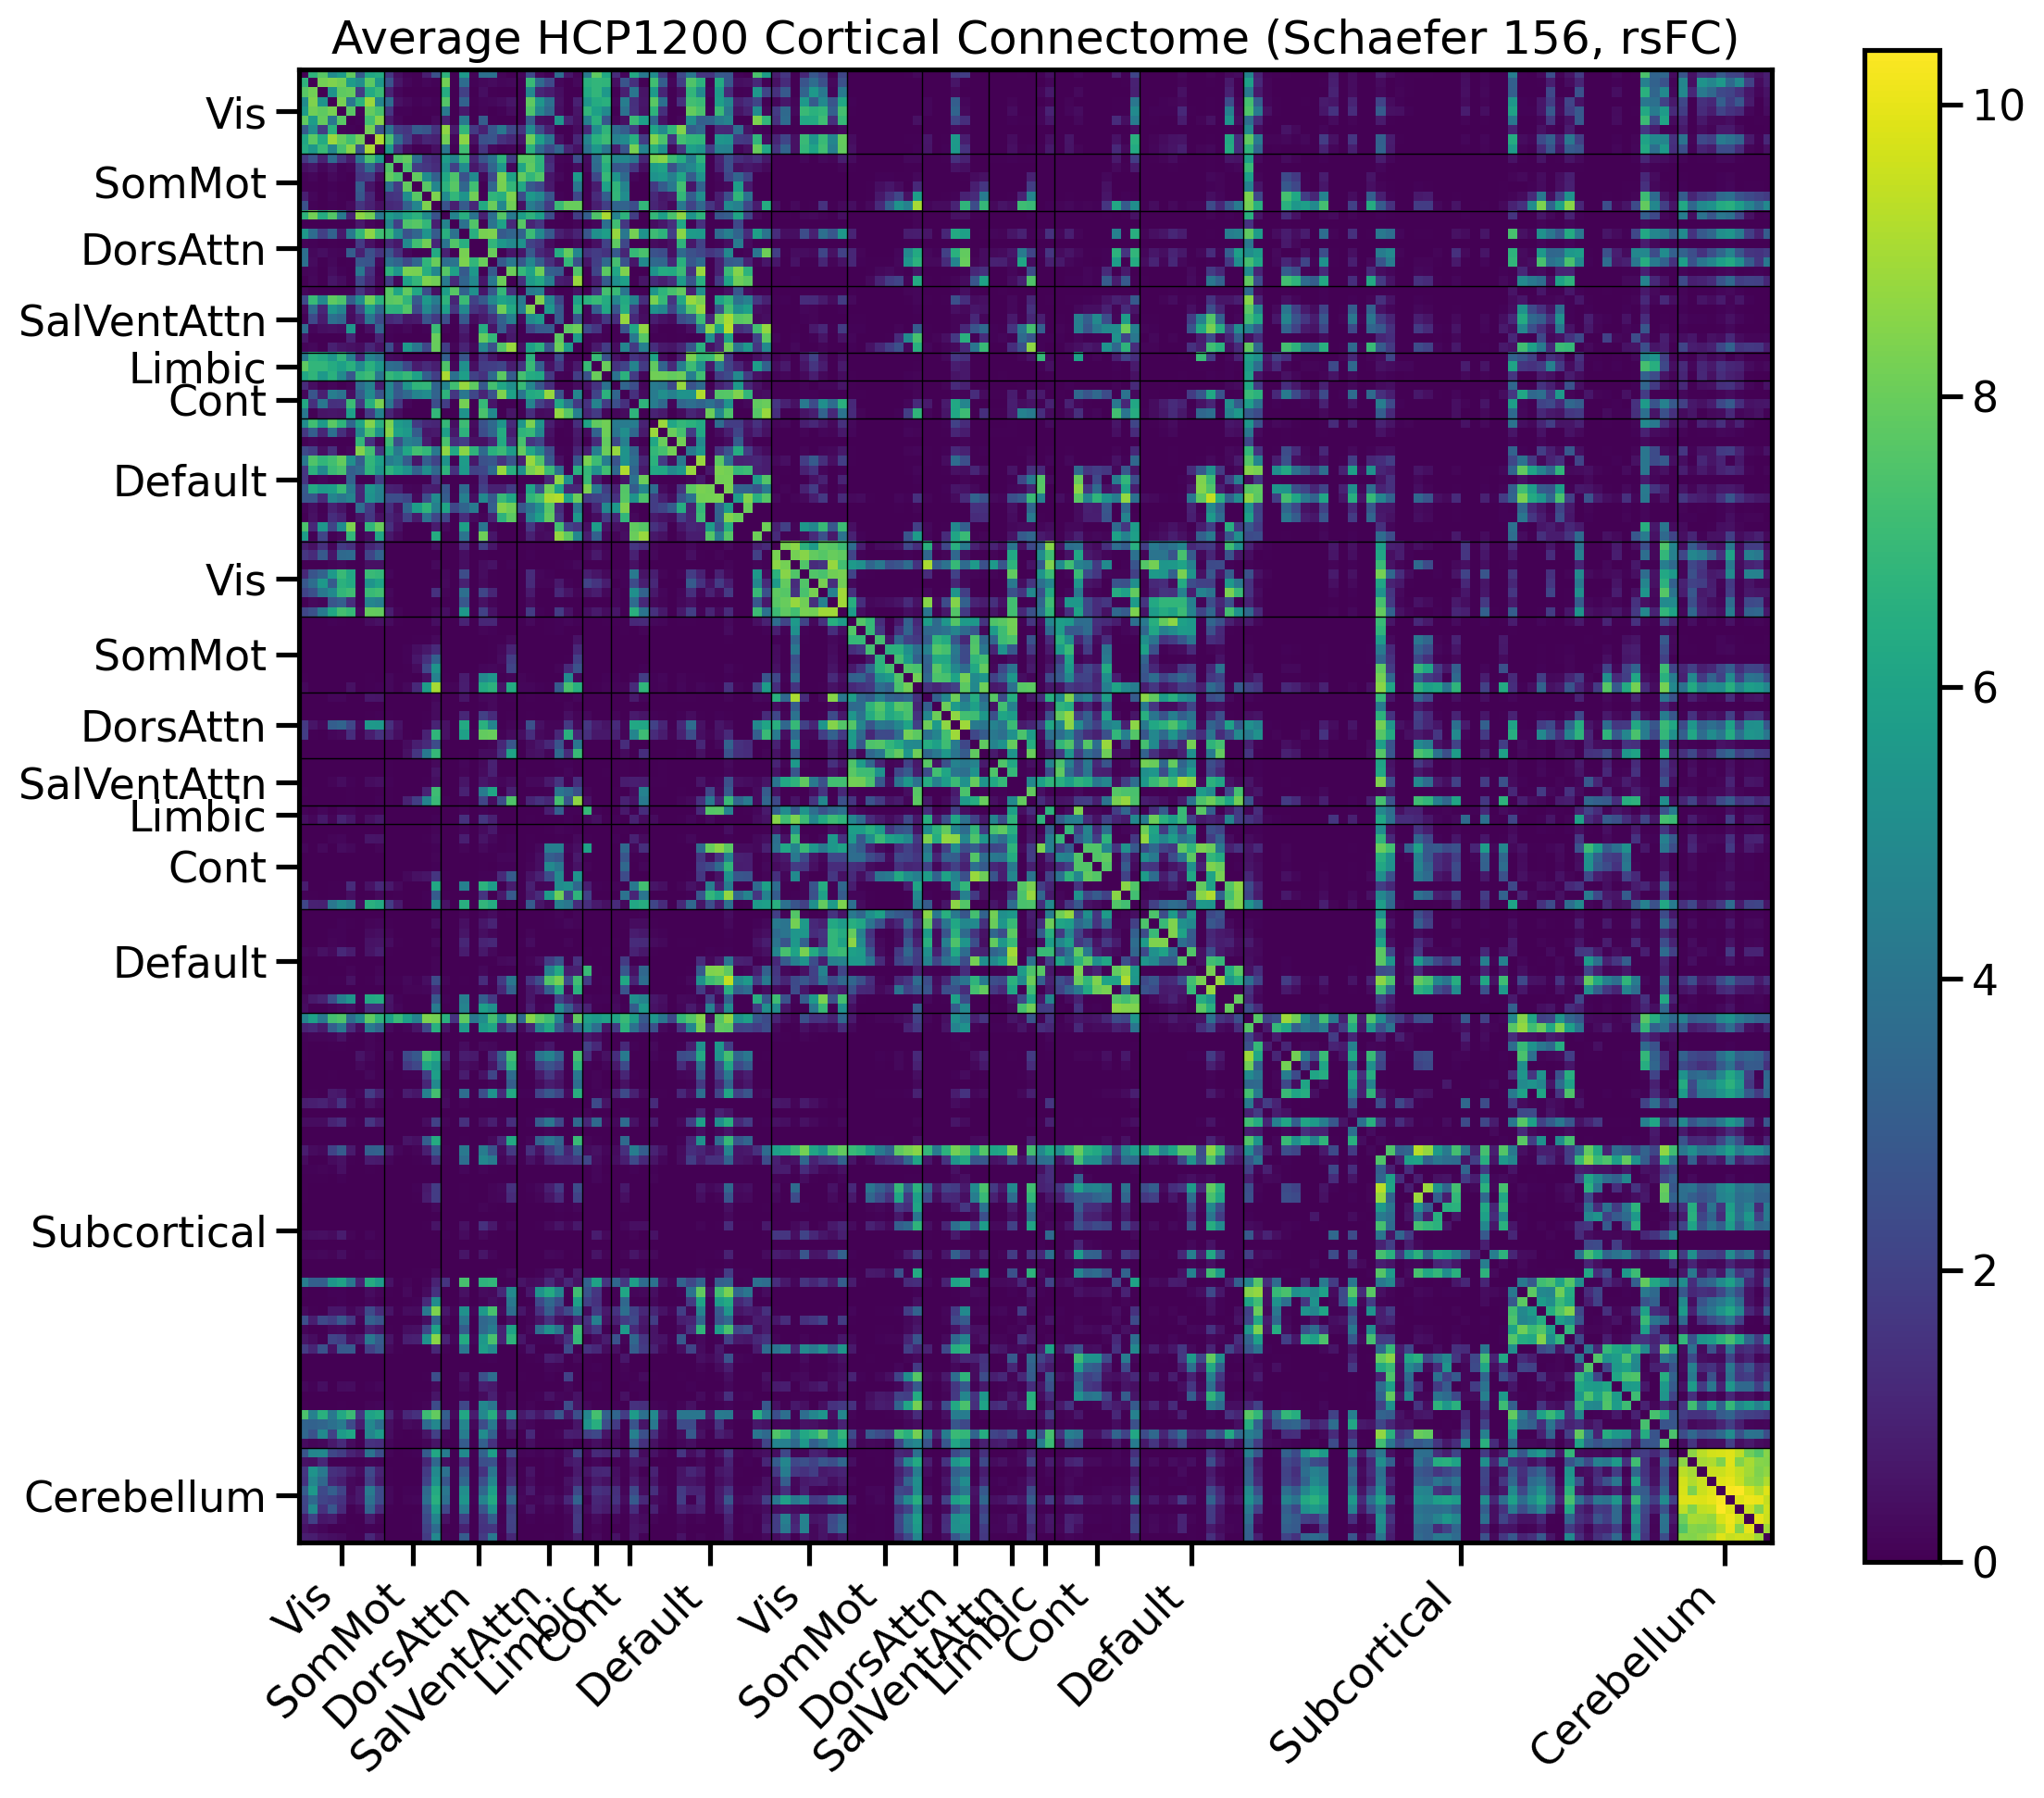

In [25]:
plot_connectome_with_networks(HCP1200_S156_connectome_mu, network_labels=None, n_rois=100, title='Average HCP1200 Cortical Connectome (Schaefer 100, rsFC)')
plot_connectome_with_networks(HCP1200_S156_connectome_mu, network_labels=schaef156_network_labels, n_rois=100, title='Average HCP1200 Cortical Connectome (Schaefer 100, rsFC)')
plot_connectome_with_networks(HCP1200_S156_connectome_mu, network_labels=schaef156_network_labels, n_rois=156, title='Average HCP1200 Cortical Connectome (Schaefer 156, rsFC)')


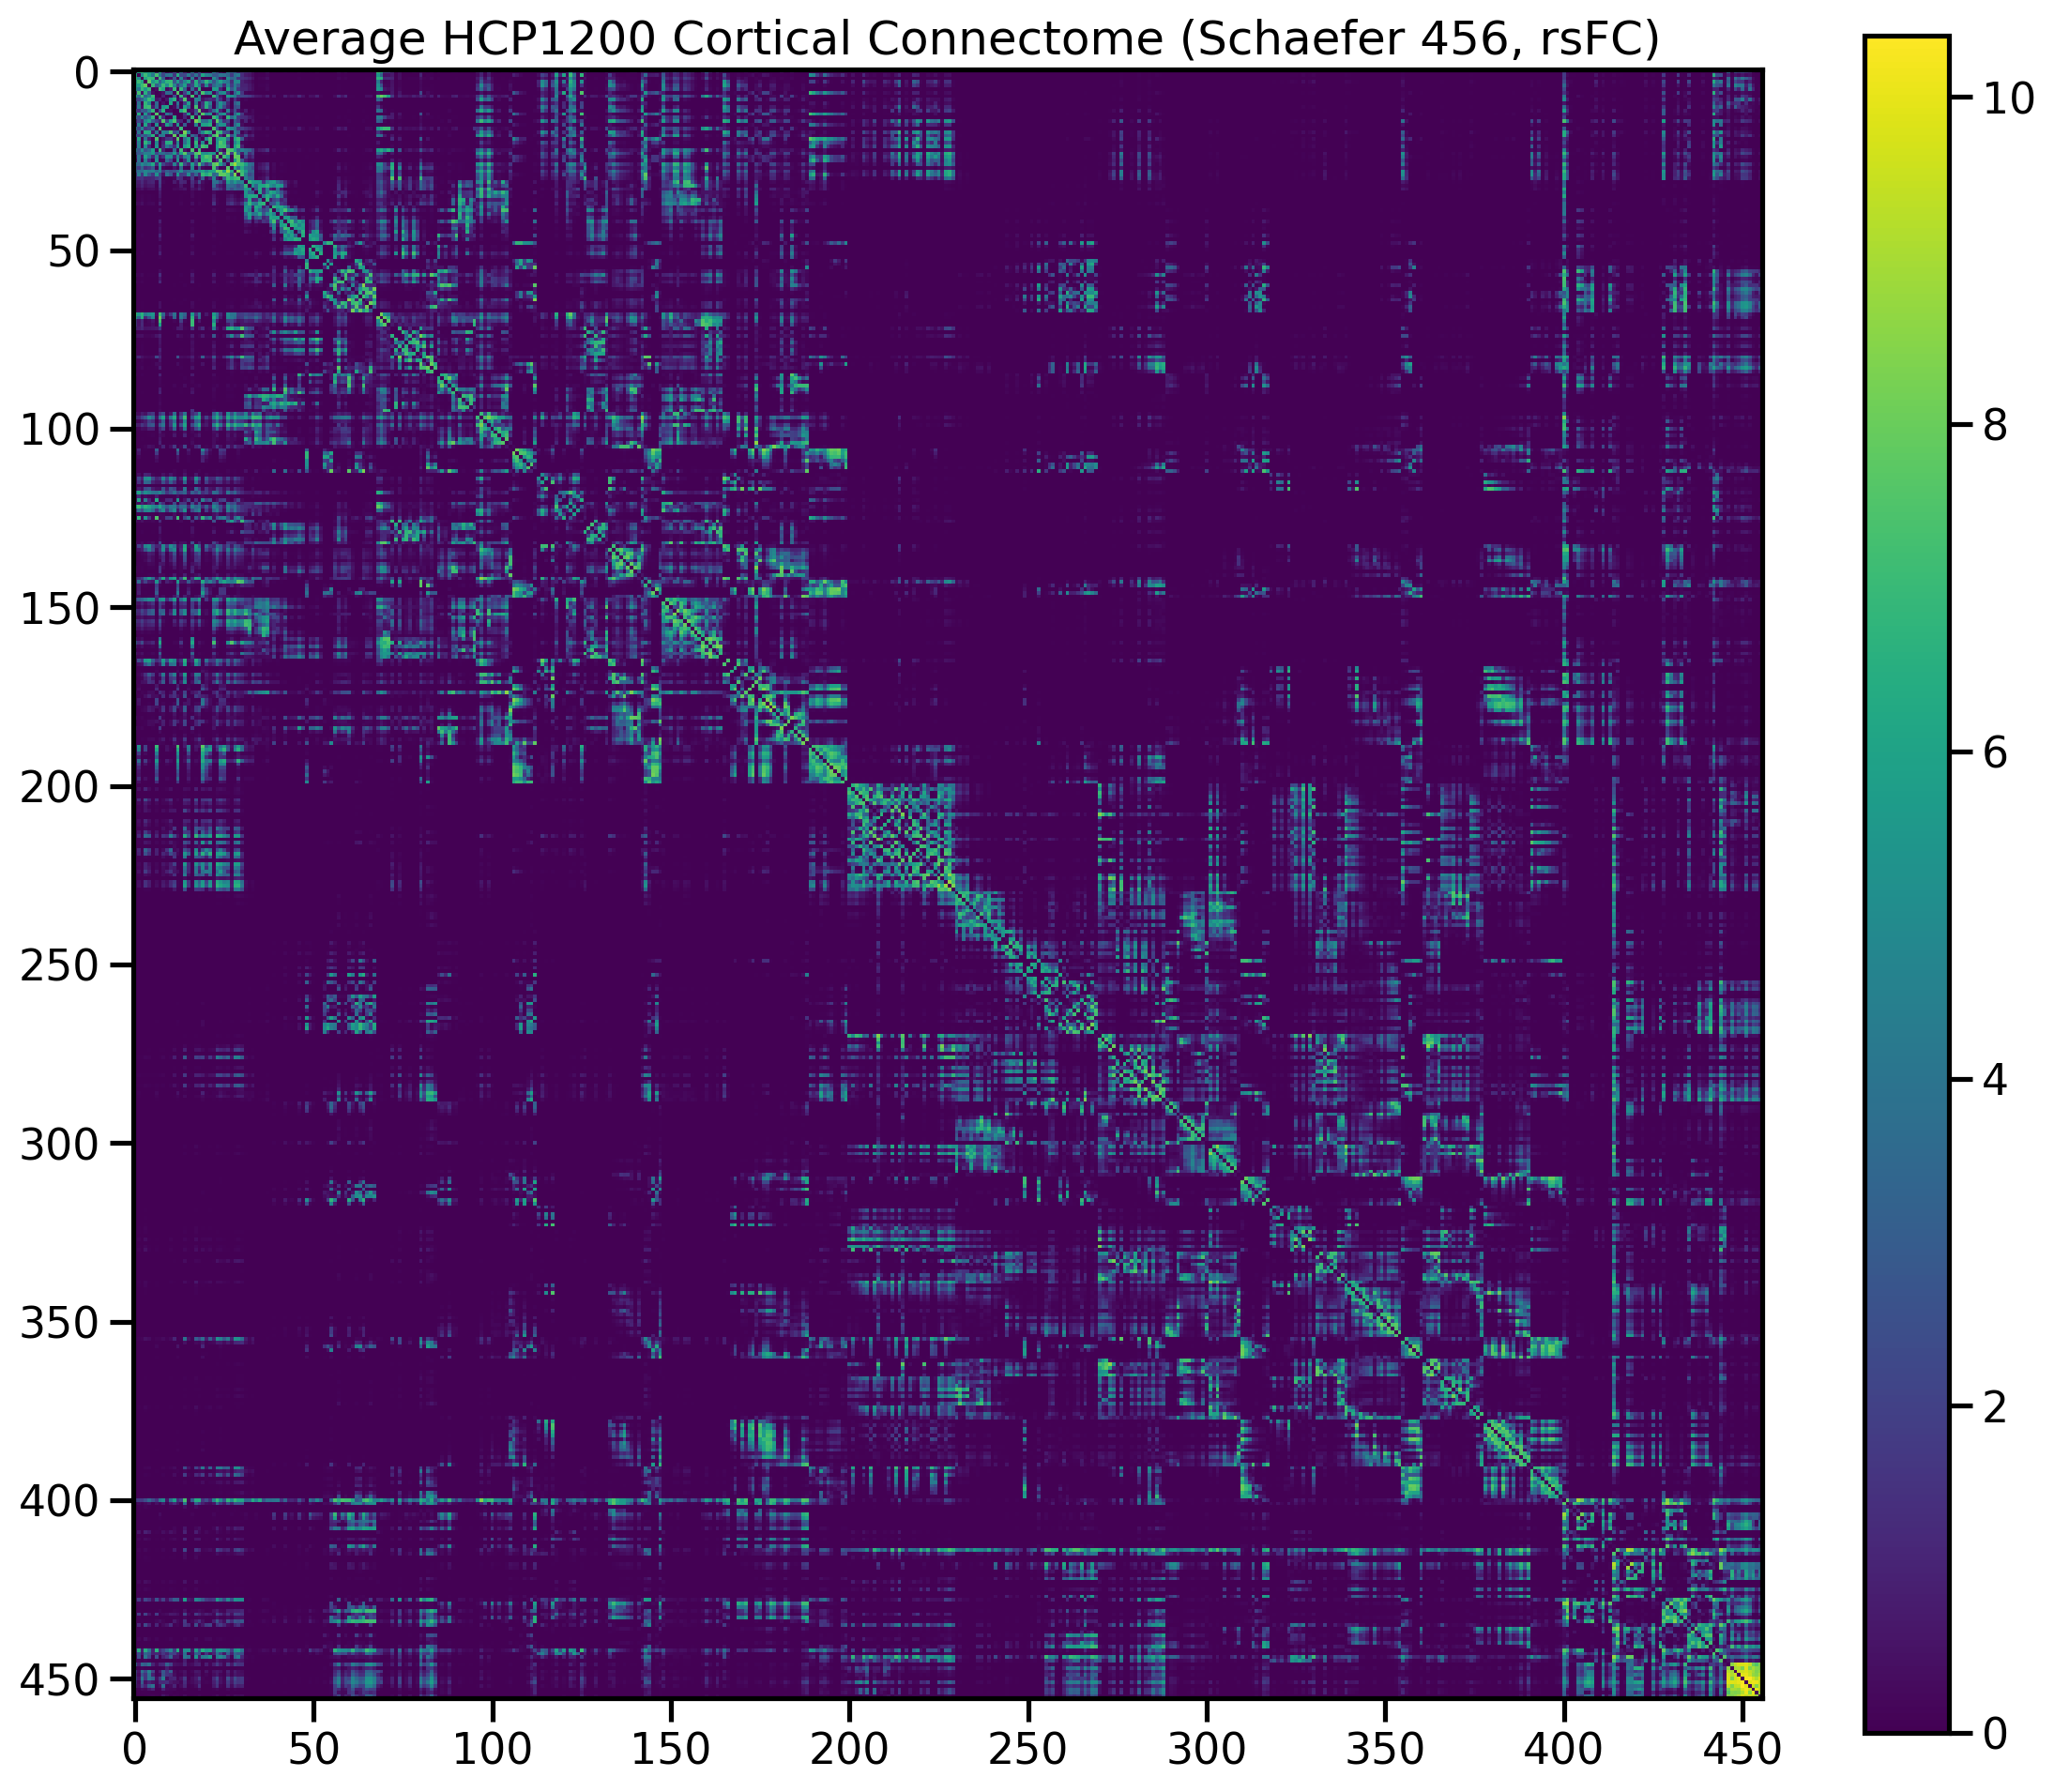

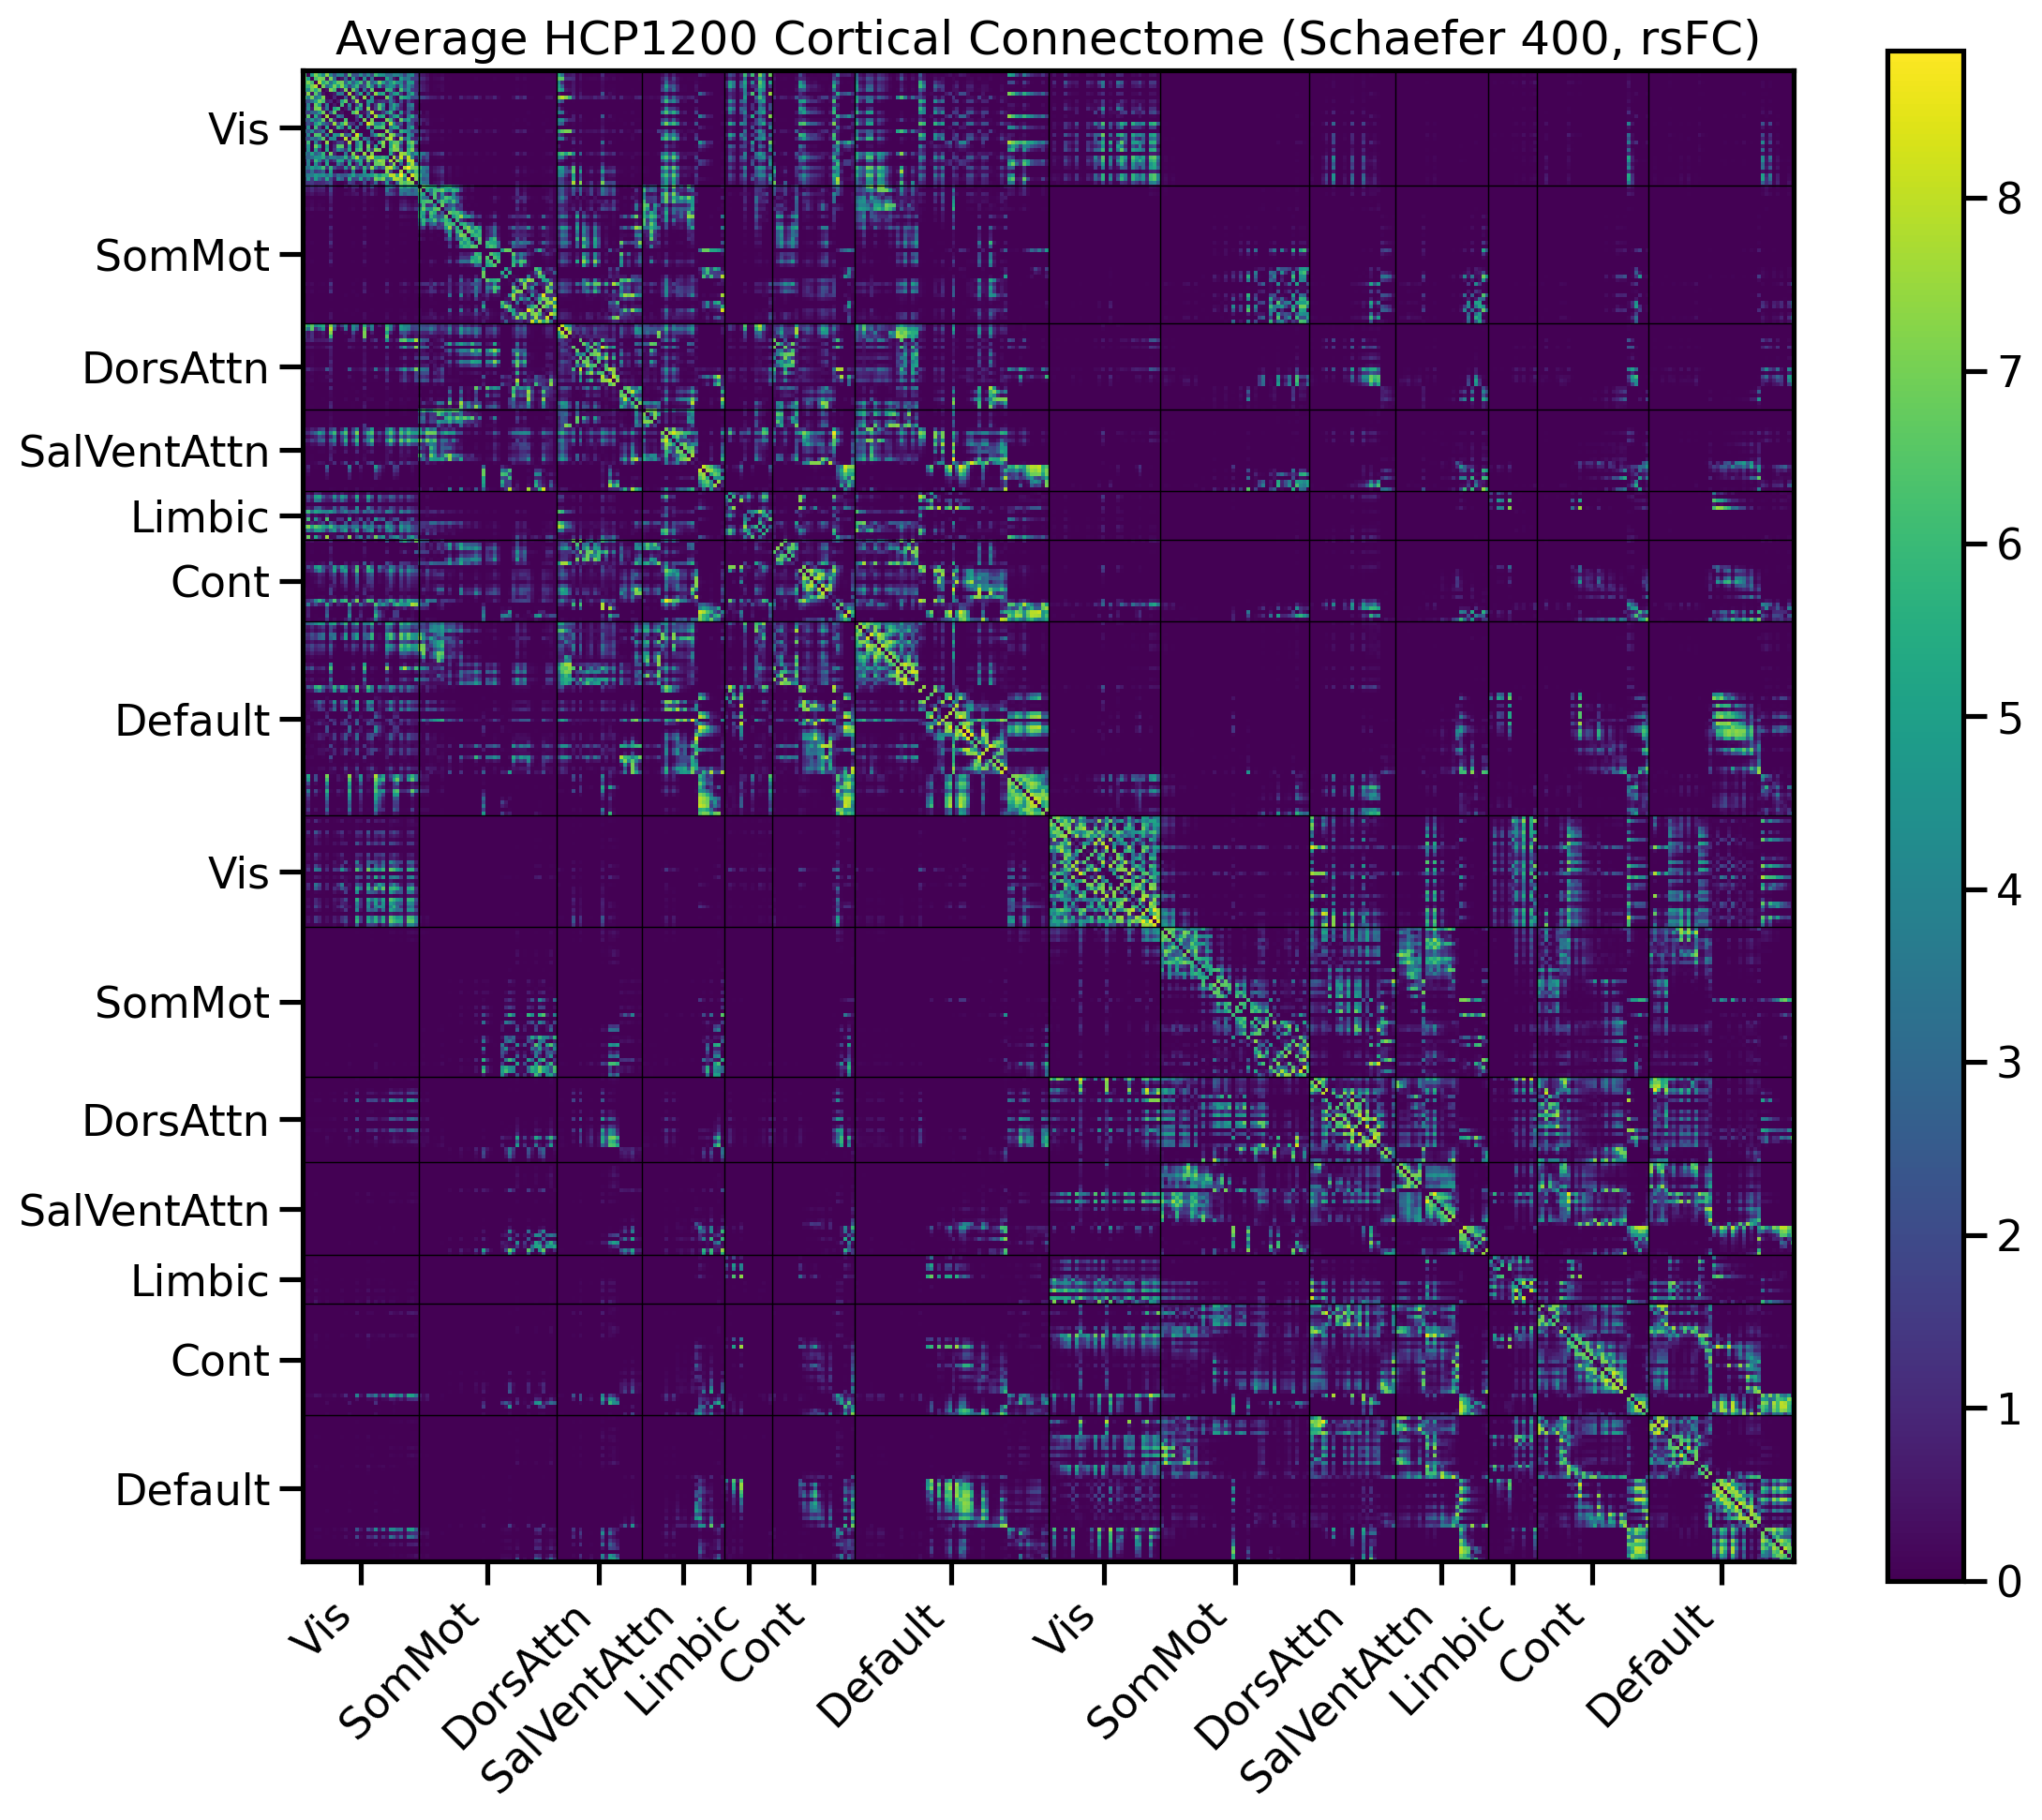

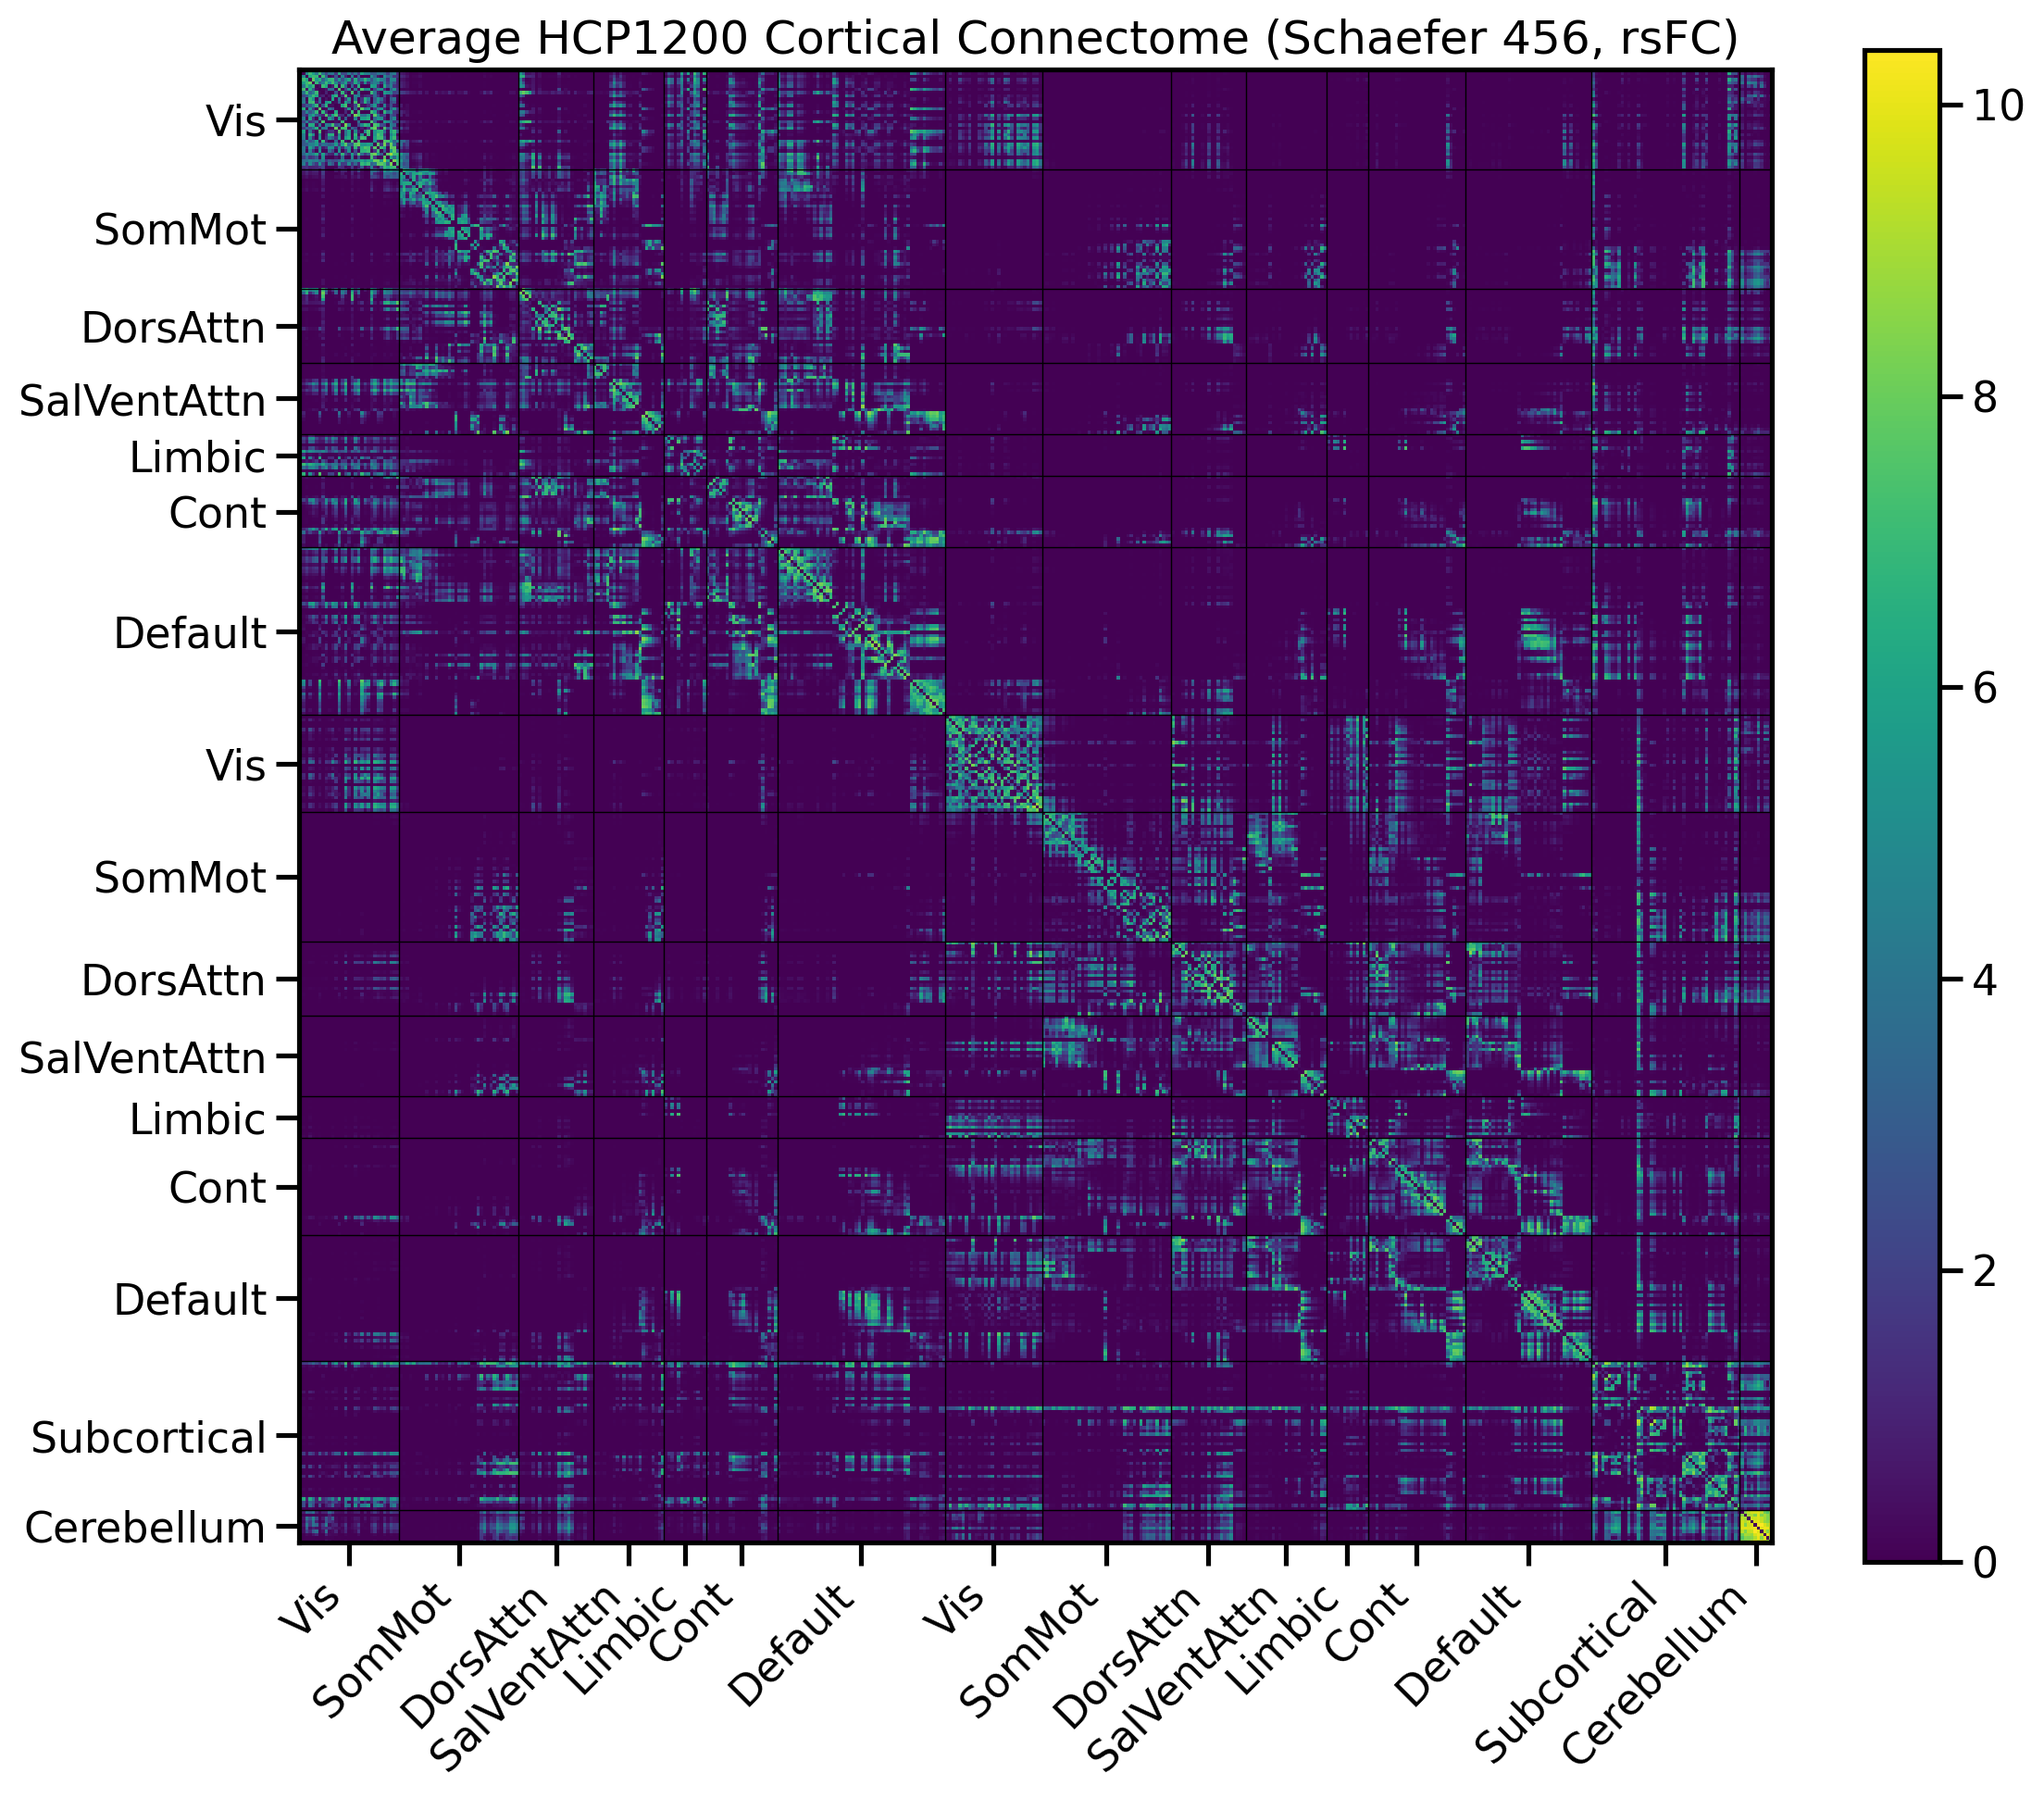

In [26]:
plot_connectome_with_networks(HCP1200_S456_connectome_mu, network_labels=None, n_rois=456, title='Average HCP1200 Cortical Connectome (Schaefer 456, rsFC)')
plot_connectome_with_networks(HCP1200_S456_connectome_mu, network_labels=schaef456_network_labels, n_rois=400, title='Average HCP1200 Cortical Connectome (Schaefer 400, rsFC)')
plot_connectome_with_networks(HCP1200_S456_connectome_mu, network_labels=schaef456_network_labels, n_rois=456, title='Average HCP1200 Cortical Connectome (Schaefer 456, rsFC)')


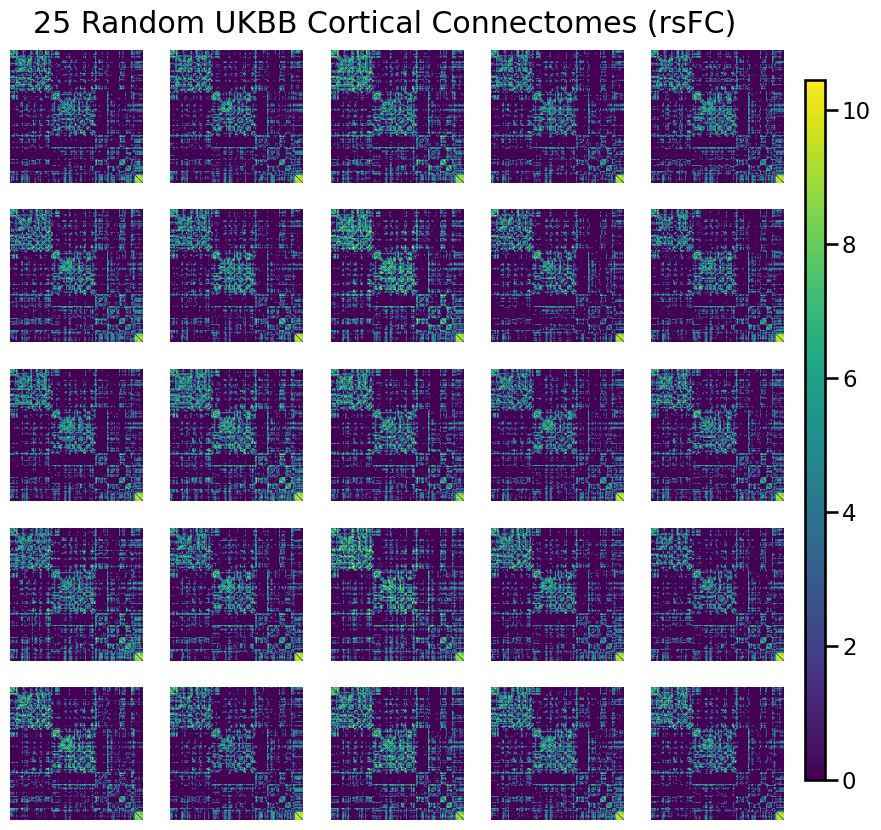

In [29]:
plot_random_connectomes(S156_connectomes, n_rows=5, max_rois=156)

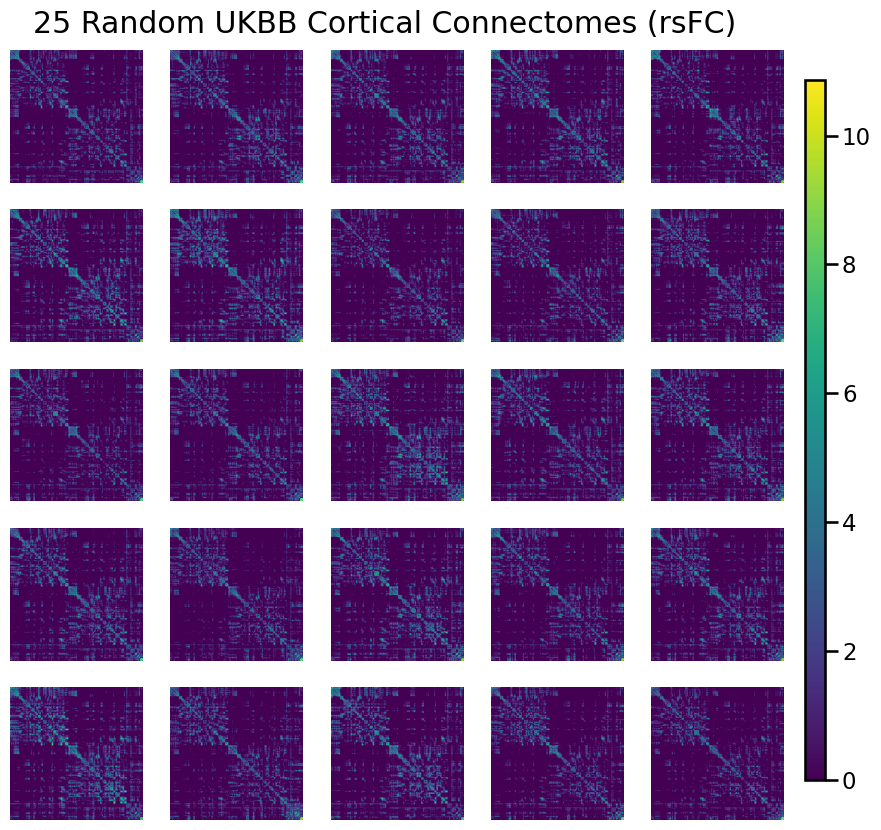

In [30]:
plot_random_connectomes(S456_connectomes, n_rows=5, max_rois=456)

## Evaluate stability

### Correlations

In [11]:
def calculate_connectome_correlations(connectomes):
    """
    Calculate correlations between each connectome and the population average.
    
    Args:
        connectomes (list): List of individual subject connectome matrices
        
    Returns:
        tuple: (mean correlation, overall p-value) if valid correlations exist,
               (None, None) otherwise
    """
    # Convert list of connectomes to array and calculate population average
    connectome_array = np.array(connectomes)
    pop_avg = np.mean(connectome_array, axis=0)
    
    # Calculate correlations between population average and each individual connectome
    correlations = []
    p_values = []
    for connectome in connectome_array:
        # Flatten the matrices to 1D arrays for correlation calculation
        pop_avg_flat = pop_avg.flatten()
        conn_flat = connectome.flatten()
        
        # Remove any pairs where either value is NaN or inf
        mask = ~(np.isnan(pop_avg_flat) | np.isnan(conn_flat) | 
                 np.isinf(pop_avg_flat) | np.isinf(conn_flat))
        pop_avg_clean = pop_avg_flat[mask]
        conn_clean = conn_flat[mask]
        
        if len(pop_avg_clean) > 0:  # Only calculate if we have valid data points
            try:
                # Calculate correlation and p-value
                corr, p_val = pearsonr(pop_avg_clean, conn_clean)
                print(f"Correlation: {corr:.3f}, p-value: {p_val:.3e}")
                correlations.append(corr)
                p_values.append(p_val)
            except Exception as e:
                print(f"Error calculating correlation: {str(e)}")
                continue

    if correlations:  # Only calculate statistics if we have valid correlations
        # Calculate mean correlation
        mean_corr = np.mean(correlations)
        # Calculate overall p-value using Fisher's method with all valid p-values
        overall_p = scipy.stats.combine_pvalues(p_values)[1]

        print(f"Mean correlation with population average: {mean_corr:.3f}")
        print(f"Overall p-value: {overall_p:.3e}")
        return mean_corr, overall_p
    else:
        print("No valid correlations could be calculated")
        return None, None

In [32]:
calculate_connectome_correlations(S156_connectomes)

Correlation: 0.882, p-value: 0.000e+00
Correlation: 0.884, p-value: 0.000e+00
Correlation: 0.887, p-value: 0.000e+00
Correlation: 0.885, p-value: 0.000e+00
Correlation: 0.868, p-value: 0.000e+00
Correlation: 0.884, p-value: 0.000e+00
Correlation: 0.882, p-value: 0.000e+00
Correlation: 0.875, p-value: 0.000e+00
Correlation: 0.874, p-value: 0.000e+00
Correlation: 0.874, p-value: 0.000e+00
Correlation: 0.856, p-value: 0.000e+00
Correlation: 0.877, p-value: 0.000e+00
Correlation: 0.834, p-value: 0.000e+00
Correlation: 0.868, p-value: 0.000e+00
Correlation: 0.886, p-value: 0.000e+00
Correlation: 0.883, p-value: 0.000e+00
Correlation: 0.882, p-value: 0.000e+00
Correlation: 0.875, p-value: 0.000e+00
Correlation: 0.877, p-value: 0.000e+00
Correlation: 0.891, p-value: 0.000e+00
Correlation: 0.886, p-value: 0.000e+00
Correlation: 0.857, p-value: 0.000e+00
Correlation: 0.897, p-value: 0.000e+00
Correlation: 0.876, p-value: 0.000e+00
Correlation: 0.882, p-value: 0.000e+00
Correlation: 0.868, p-val

  statistic = -2 * np.sum(np.log(pvalues))



Mean correlation with population average: 0.873
Overall p-value: 0.000e+00


(0.8732551072549755, 0.0)

In [33]:
calculate_connectome_correlations(S456_connectomes)

Correlation: 0.827, p-value: 0.000e+00
Correlation: 0.823, p-value: 0.000e+00
Correlation: 0.831, p-value: 0.000e+00
Correlation: 0.834, p-value: 0.000e+00
Correlation: 0.790, p-value: 0.000e+00
Correlation: 0.827, p-value: 0.000e+00
Correlation: 0.828, p-value: 0.000e+00
Correlation: 0.811, p-value: 0.000e+00
Correlation: 0.818, p-value: 0.000e+00
Correlation: 0.808, p-value: 0.000e+00
Correlation: 0.806, p-value: 0.000e+00
Correlation: 0.813, p-value: 0.000e+00
Correlation: 0.780, p-value: 0.000e+00
Correlation: 0.791, p-value: 0.000e+00
Correlation: 0.829, p-value: 0.000e+00
Correlation: 0.834, p-value: 0.000e+00
Correlation: 0.831, p-value: 0.000e+00
Correlation: 0.815, p-value: 0.000e+00
Correlation: 0.814, p-value: 0.000e+00
Correlation: 0.833, p-value: 0.000e+00
Correlation: 0.829, p-value: 0.000e+00
Correlation: 0.796, p-value: 0.000e+00
Correlation: 0.829, p-value: 0.000e+00
Correlation: 0.810, p-value: 0.000e+00
Correlation: 0.830, p-value: 0.000e+00
Correlation: 0.808, p-val

(0.8152990193720602, 0.0)

### Residuals

In [34]:
def compute_connectome_residuals(individual_connectomes, population_average, n_regions=None):
    """
    Compute residuals between individual connectomes and population average.
    
    Parameters:
    -----------
    individual_connectomes : list
        List of individual connectivity matrices
    population_average : numpy.ndarray 
        Population average connectivity matrix
    n_regions : int, optional
        Number of regions to include in analysis. If None, uses all regions (default None)
        
    Returns:
    --------
    numpy.ndarray
        1D array of flattened residuals
    """
    # Get max number of regions from population average shape
    max_regions = population_average.shape[0]
    
    # Use all regions if n_regions not specified or is larger than max
    n_regions = min(n_regions, max_regions) if n_regions is not None else max_regions
    
    # Select subset of regions
    subset_connectomes = [conn[:n_regions, :n_regions] for conn in individual_connectomes]
    pop_avg_subset = population_average[:n_regions, :n_regions]
    
    print(f"Original connectome shape: {individual_connectomes[0].shape}")
    print(f"Subset connectome shape: {subset_connectomes[0].shape}")

    # Convert to numpy array and compute residuals
    connectome_array = np.array(subset_connectomes)
    residuals = connectome_array - pop_avg_subset

    # Flatten residuals into 1D array
    return residuals.flatten()

def plot_residual_distribution(all_residuals):
    """
    Plot distribution of residuals between individual connectomes and population average.
    Tests and visualizes if the distribution is Gaussian.
    
    Parameters:
    -----------
    all_residuals : numpy.ndarray
        1D array of flattened residuals
    """
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot histogram without KDE
    sns.histplot(all_residuals, kde=False, stat='density', bins=100)
    
    # Fit normal distribution and plot
    mu, std = np.nanmean(all_residuals), np.nanstd(all_residuals)
    
    plt.title('Distribution of Residuals All Connectomes vs. Population Average')
    plt.xlabel('Residual Value')
    plt.ylabel('Density')
    plt.legend()
    
    # Perform Shapiro-Wilk test for normality
    statistic, p_value = stats.shapiro(all_residuals[~np.isnan(all_residuals)])
    
    # Add summary statistics and normality test results as text
    stats_text = f'Mean: {mu:.3f}\n'
    stats_text += f'Std: {std:.3f}\n'
    
    stats_text += f'\nShapiro-Wilk Test:\n'
    stats_text += f'Statistic: {statistic:.3f}\n'
    stats_text += f'p-value: {p_value:.3e}\n'
    stats_text += f'Distribution is {"Normal" if p_value > 0.05 else "Not Normal"}'
    
    plt.text(0.95, 0.95, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()

In [35]:
all_S156_residuals = compute_connectome_residuals(S156_connectomes, HCP1200_S156_connectome_mu)
all_S456_residuals = compute_connectome_residuals(S456_connectomes, HCP1200_S456_connectome_mu)

Original connectome shape: (156, 156)
Subset connectome shape: (156, 156)
Original connectome shape: (456, 456)
Subset connectome shape: (456, 456)


  warnings.warn("p-value may not be accurate for N > 5000.")



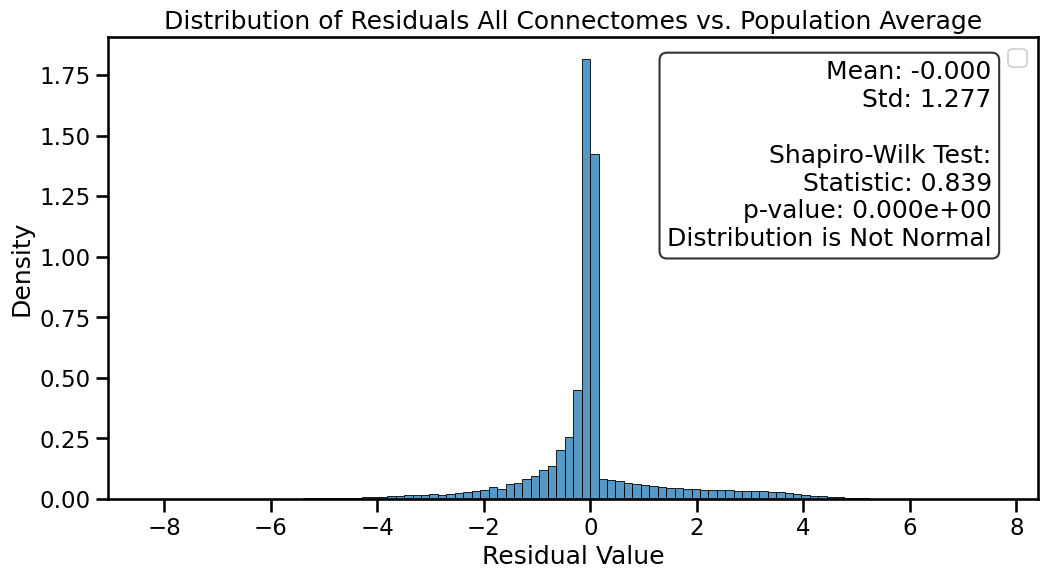

In [36]:
plot_residual_distribution(all_S156_residuals)

  warnings.warn("p-value may not be accurate for N > 5000.")



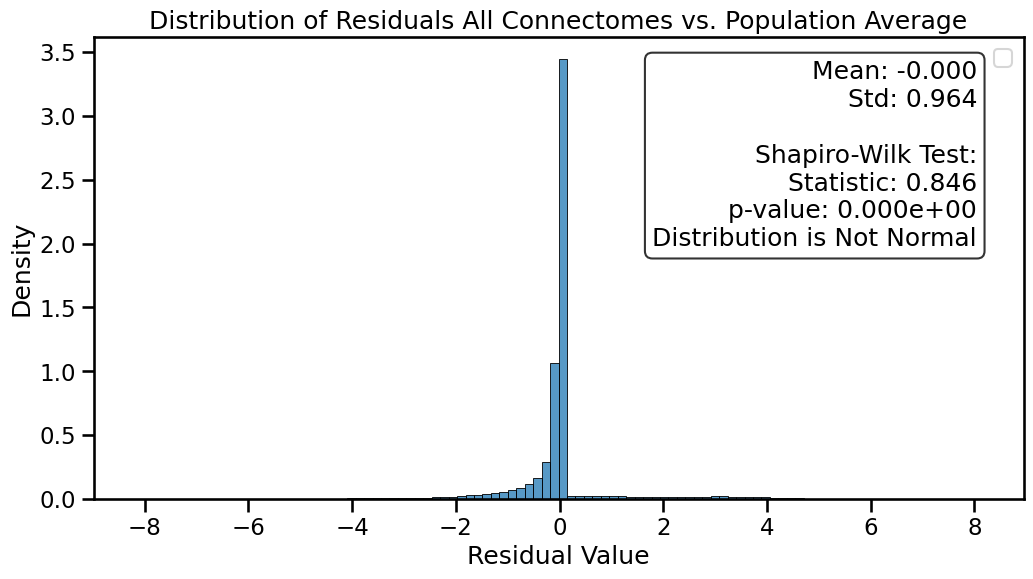

In [37]:
plot_residual_distribution(all_S456_residuals)

In [38]:
def plot_random_edge_distribution(connectomes, max_regions, avg_connectome):
    """
    Plot distribution of values for a random edge in the connectome and test for normality.
    
    Parameters:
    -----------
    connectomes : list
        List of connectivity matrices
    max_regions : int
        Number of regions to subset (e.g. first 100)
    avg_connectome : numpy.ndarray
        Population average connectome matrix
    """
    # Convert to numpy array and subset
    connectome_array = np.array(connectomes)
    n_subjects = len(connectome_array)
    
    # Get random indices for row and column within max_regions
    row_idx = np.random.randint(0, max_regions)
    col_idx = np.random.randint(0, max_regions)
    
    # Get distribution of values for this edge across subjects
    edge_values = connectome_array[:, row_idx, col_idx]
    
    # Perform Shapiro-Wilk test for normality
    statistic, p_value = stats.shapiro(edge_values)
    
    # Get max possible range from population average
    max_abs_val = np.max(np.abs(avg_connectome))
    x_range = (-max_abs_val, max_abs_val)
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot histogram with KDE
    sns.histplot(edge_values, kde=True, stat='count', bins=30)
    plt.xlim(x_range)
    
    # Add vertical line for population average
    avg_value = avg_connectome[row_idx, col_idx]
    plt.axvline(x=avg_value, color='r', linestyle='--', 
                label=f'Population Average: {avg_value:.3f}')
    
    plt.title(f'Distribution of Edge Values for Regions ({row_idx}, {col_idx})')
    plt.xlabel('Connectivity Value')
    plt.ylabel('Count')
    plt.legend()
    
    # Adjust layout to prevent text cutoff
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()

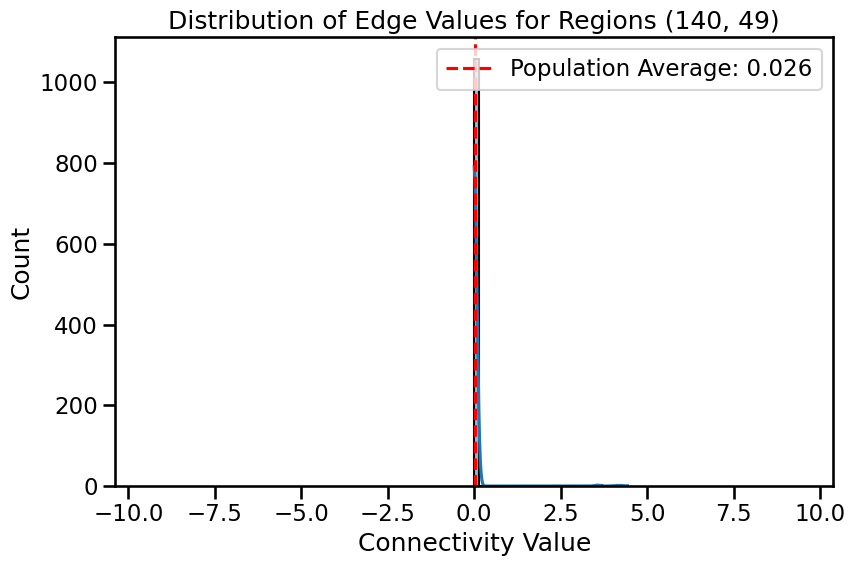

In [39]:
plot_random_edge_distribution(S156_connectomes, 156, HCP1200_S156_connectome_mu)

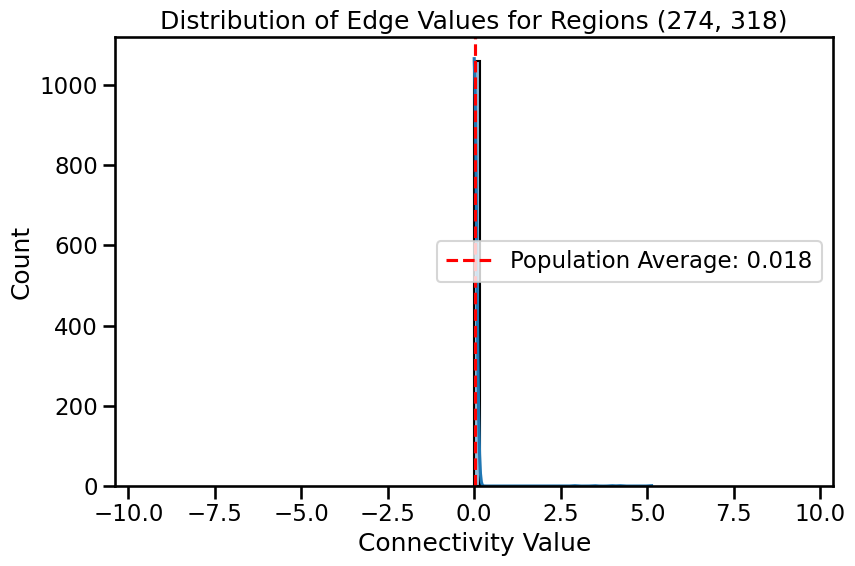

In [41]:
plot_random_edge_distribution(S456_connectomes, 456, HCP1200_S456_connectome_mu)

### Connectome subset KDEs

In [17]:
def plot_edge_distributions(connectomes, max_regions, avg_connectome):
    """
    Plot KDE distributions for all edges in the upper triangle of the connectome.
    
    Parameters:
    -----------
    connectomes : list
        List of connectivity matrices
    max_regions : int
        Number of regions to subset (e.g. first 10)
    avg_connectome : numpy.ndarray
        Population average connectome matrix
    """
    # Convert to numpy array and subset
    connectome_array = np.array(connectomes)
    n_subjects = len(connectome_array)
    
    # First plot the subsetted connectome
    subset_connectome = avg_connectome[:max_regions, :max_regions]
    
    # Create mask for upper triangle
    mask = np.tril(np.ones_like(subset_connectome))
    
    # Create masked array
    masked_connectome = np.ma.array(subset_connectome, mask=mask)
    
    plt.figure(figsize=(12, 10), dpi=200)
    plt.imshow(masked_connectome, cmap='viridis', vmin=0, vmax=10)
    plt.colorbar()
    plt.title(f'Average Cortical Connectome Subset (First {max_regions} regions)')
    
    # Set integer ticks
    plt.xticks(range(0, max_regions, 10))
    plt.yticks(range(0, max_regions, 10))
    
    plt.show()
    
    # KDE part
    # Create figure with subplots for upper triangle
    n_plots = (max_regions * (max_regions - 1)) // 2  # Number of edges in upper triangle
    n_rows = max_regions - 1
    n_cols = max_regions - 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 24))  # Made height equal to width
    
    # Get max possible range from population average for consistent scaling
    max_abs_val = np.max(np.abs(avg_connectome))
    x_range = (-max_abs_val, max_abs_val)
    
    # Plot KDE for each edge in upper triangle
    plot_idx = 0
    for i in range(max_regions):
        for j in range(i+1, max_regions):
            # Get row and column index in subplot grid
            row = i
            col = j-1
            
            # Get distribution of values for this edge across subjects
            edge_values = connectome_array[:, i, j]
            
            # Get average value for background color
            avg_value = avg_connectome[i, j]
            
            # Set background color based on average value, normalized to 0-10 range
            axes[row, col].set_facecolor(plt.cm.viridis(avg_value/10))
            
            # Plot KDE without labels and without black borders
            sns.kdeplot(edge_values, ax=axes[row, col], color='black', linewidth=1)
            axes[row, col].spines['top'].set_visible(False)
            axes[row, col].spines['right'].set_visible(False)
            axes[row, col].spines['bottom'].set_visible(False)
            axes[row, col].spines['left'].set_visible(False)
            axes[row, col].set_xlim(x_range)
            
            # Make subplot square by setting aspect ratio to 'equal'
            axes[row, col].set_aspect(1.0/axes[row, col].get_data_ratio())
            
            # Add vertical line for population average
            axes[row, col].axvline(x=avg_value, color='blue', linestyle='--')
            
            # Remove all labels and ticks
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            axes[row, col].set_xlabel('')
            axes[row, col].set_ylabel('')
            
            plot_idx += 1
    
    # Remove empty subplots in lower triangle
    for i in range(n_rows):
        for j in range(n_cols):
            if j <= i:
                axes[i,j].remove()
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

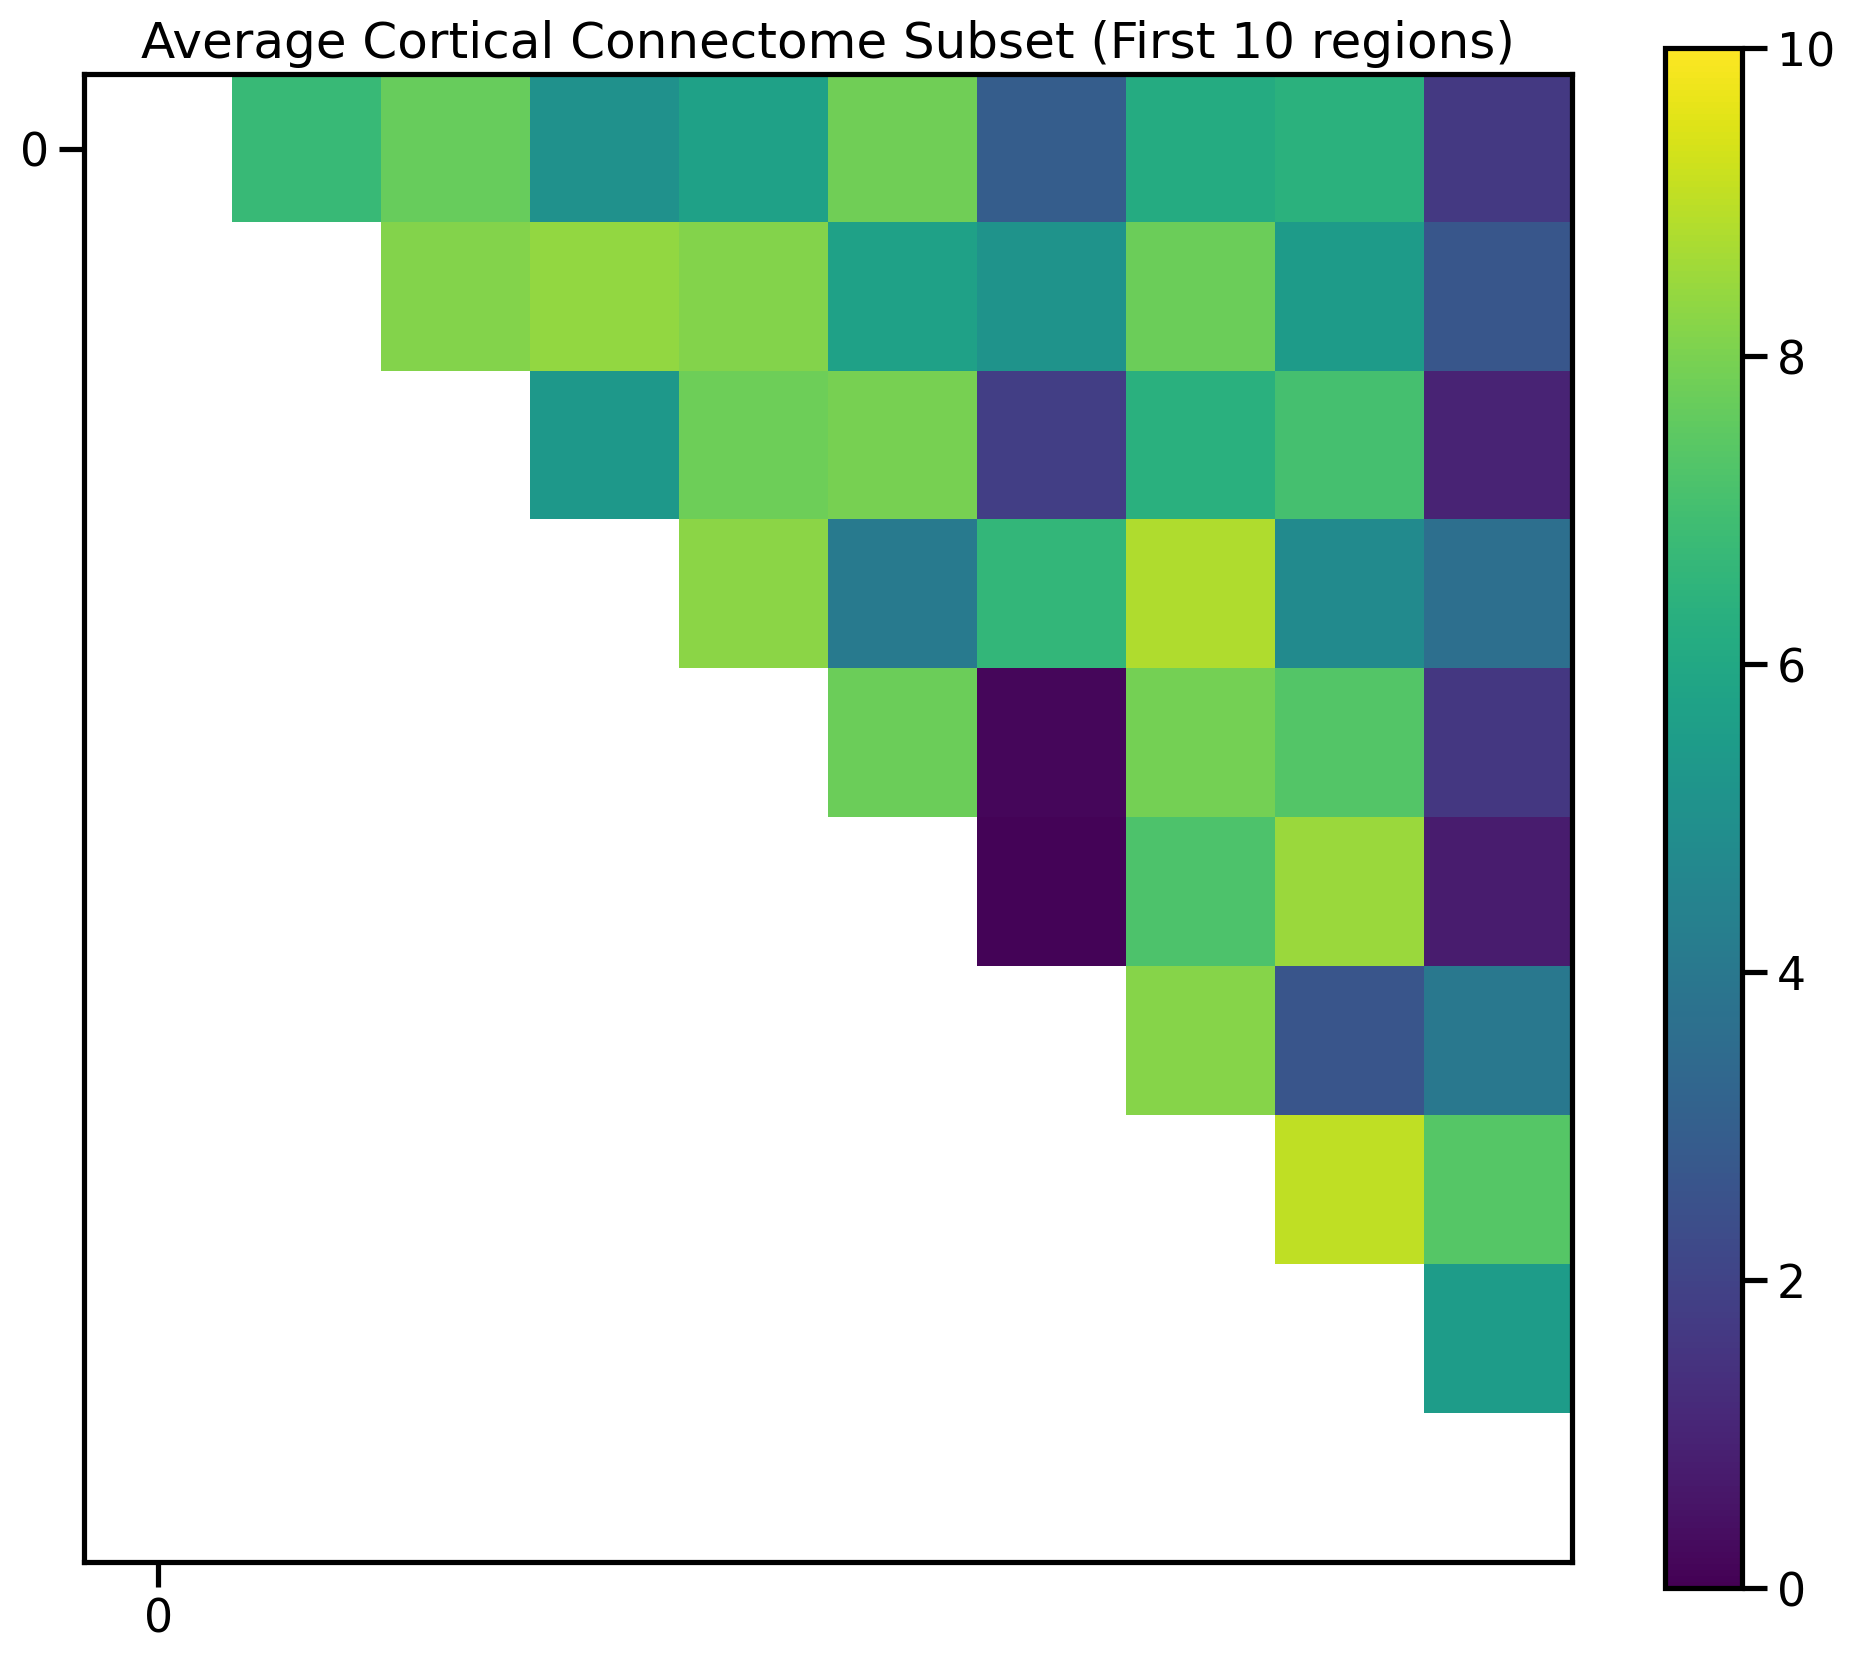

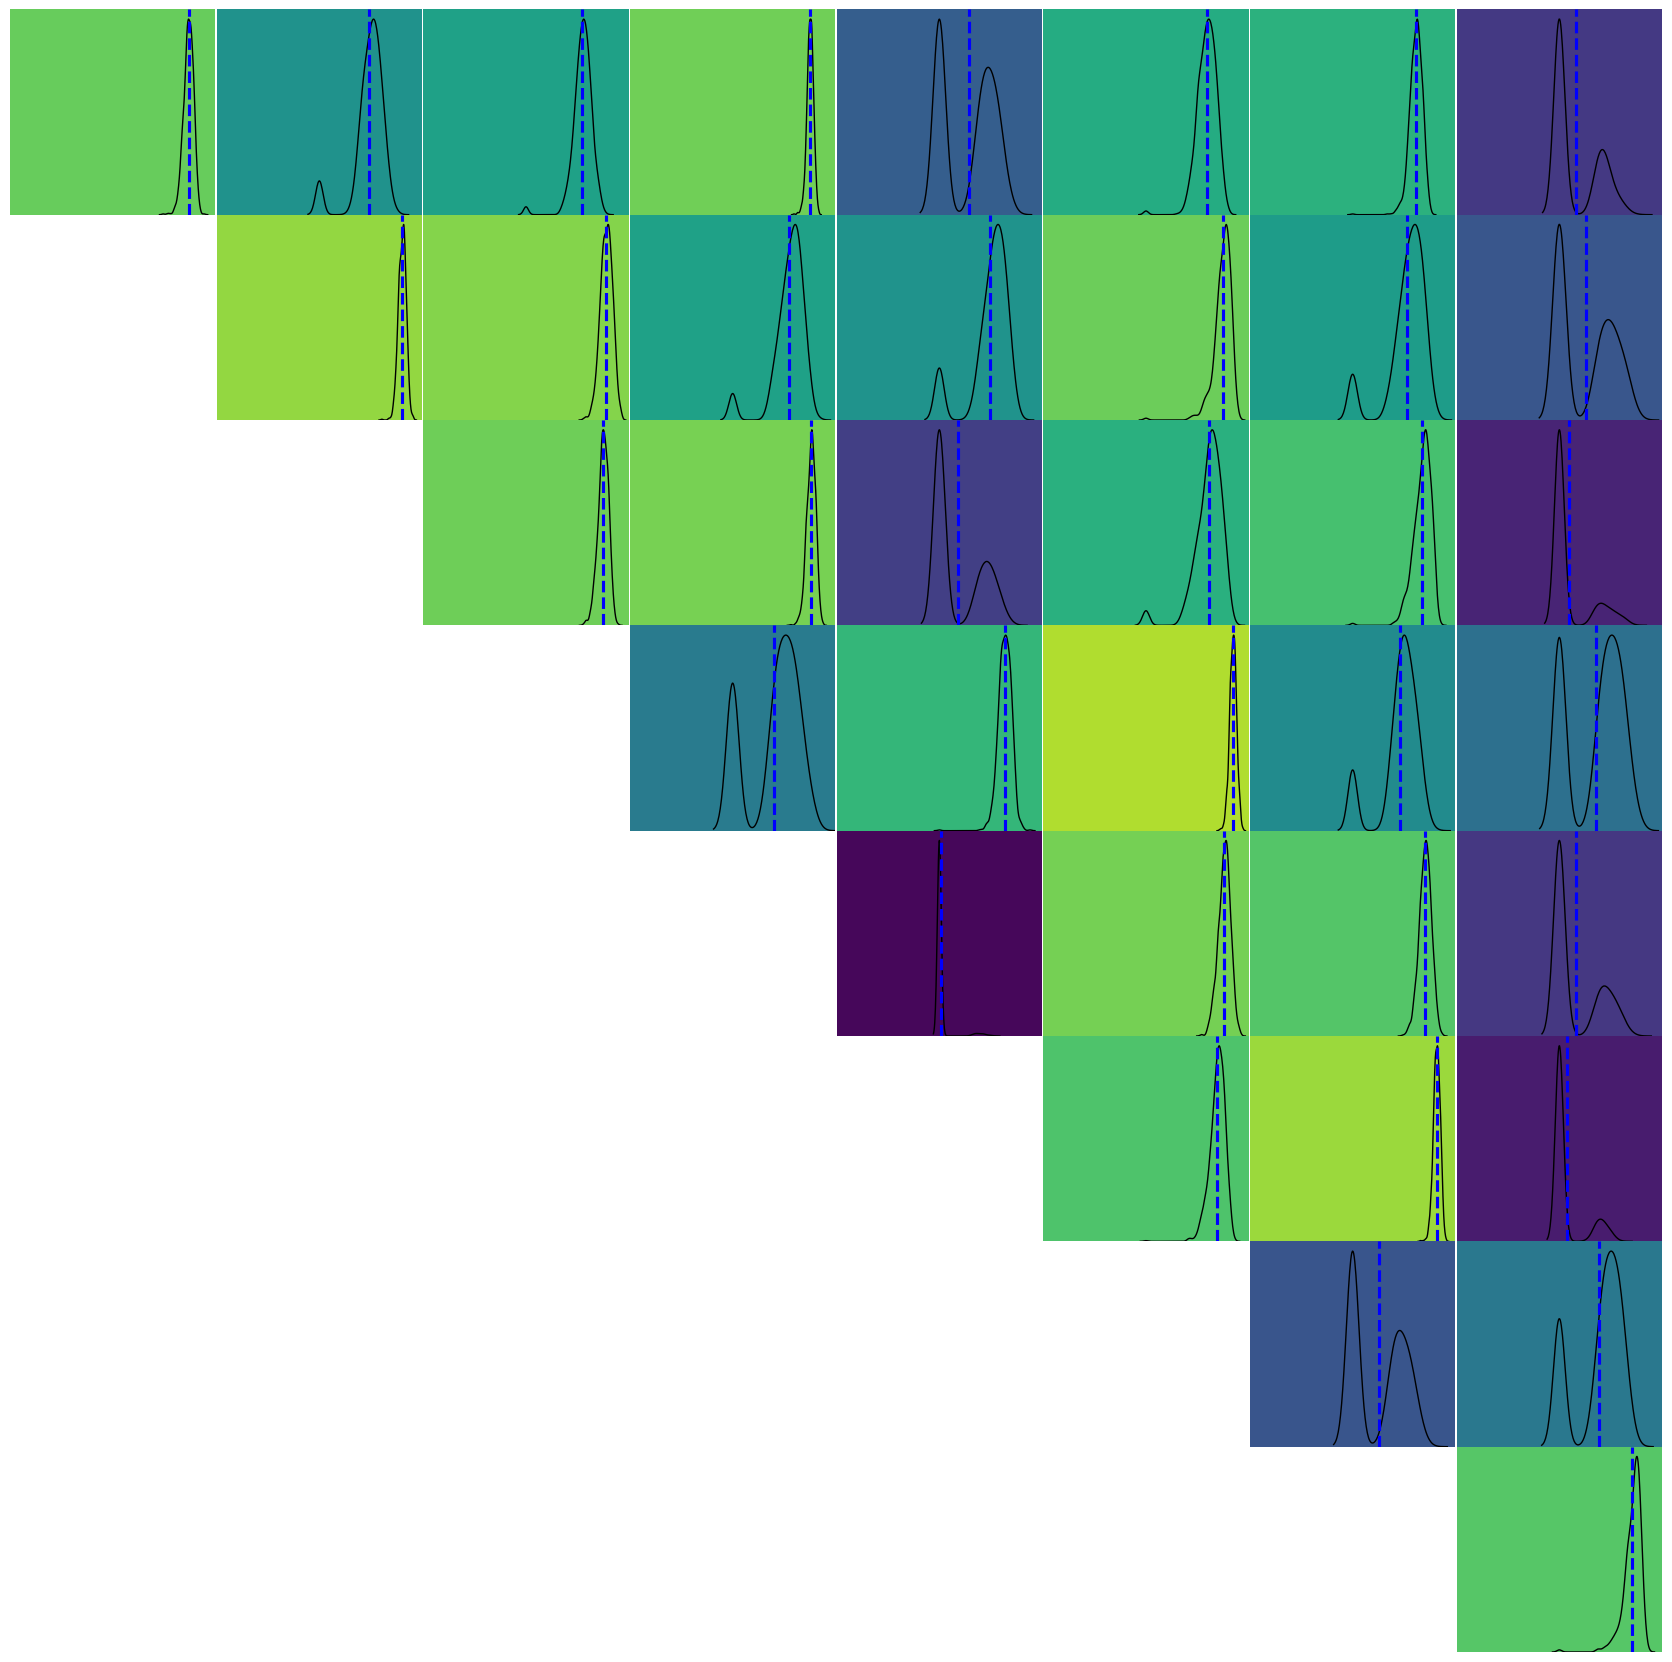

In [18]:
plot_edge_distributions(S156_connectomes, 10, HCP1200_S156_connectome_mu)

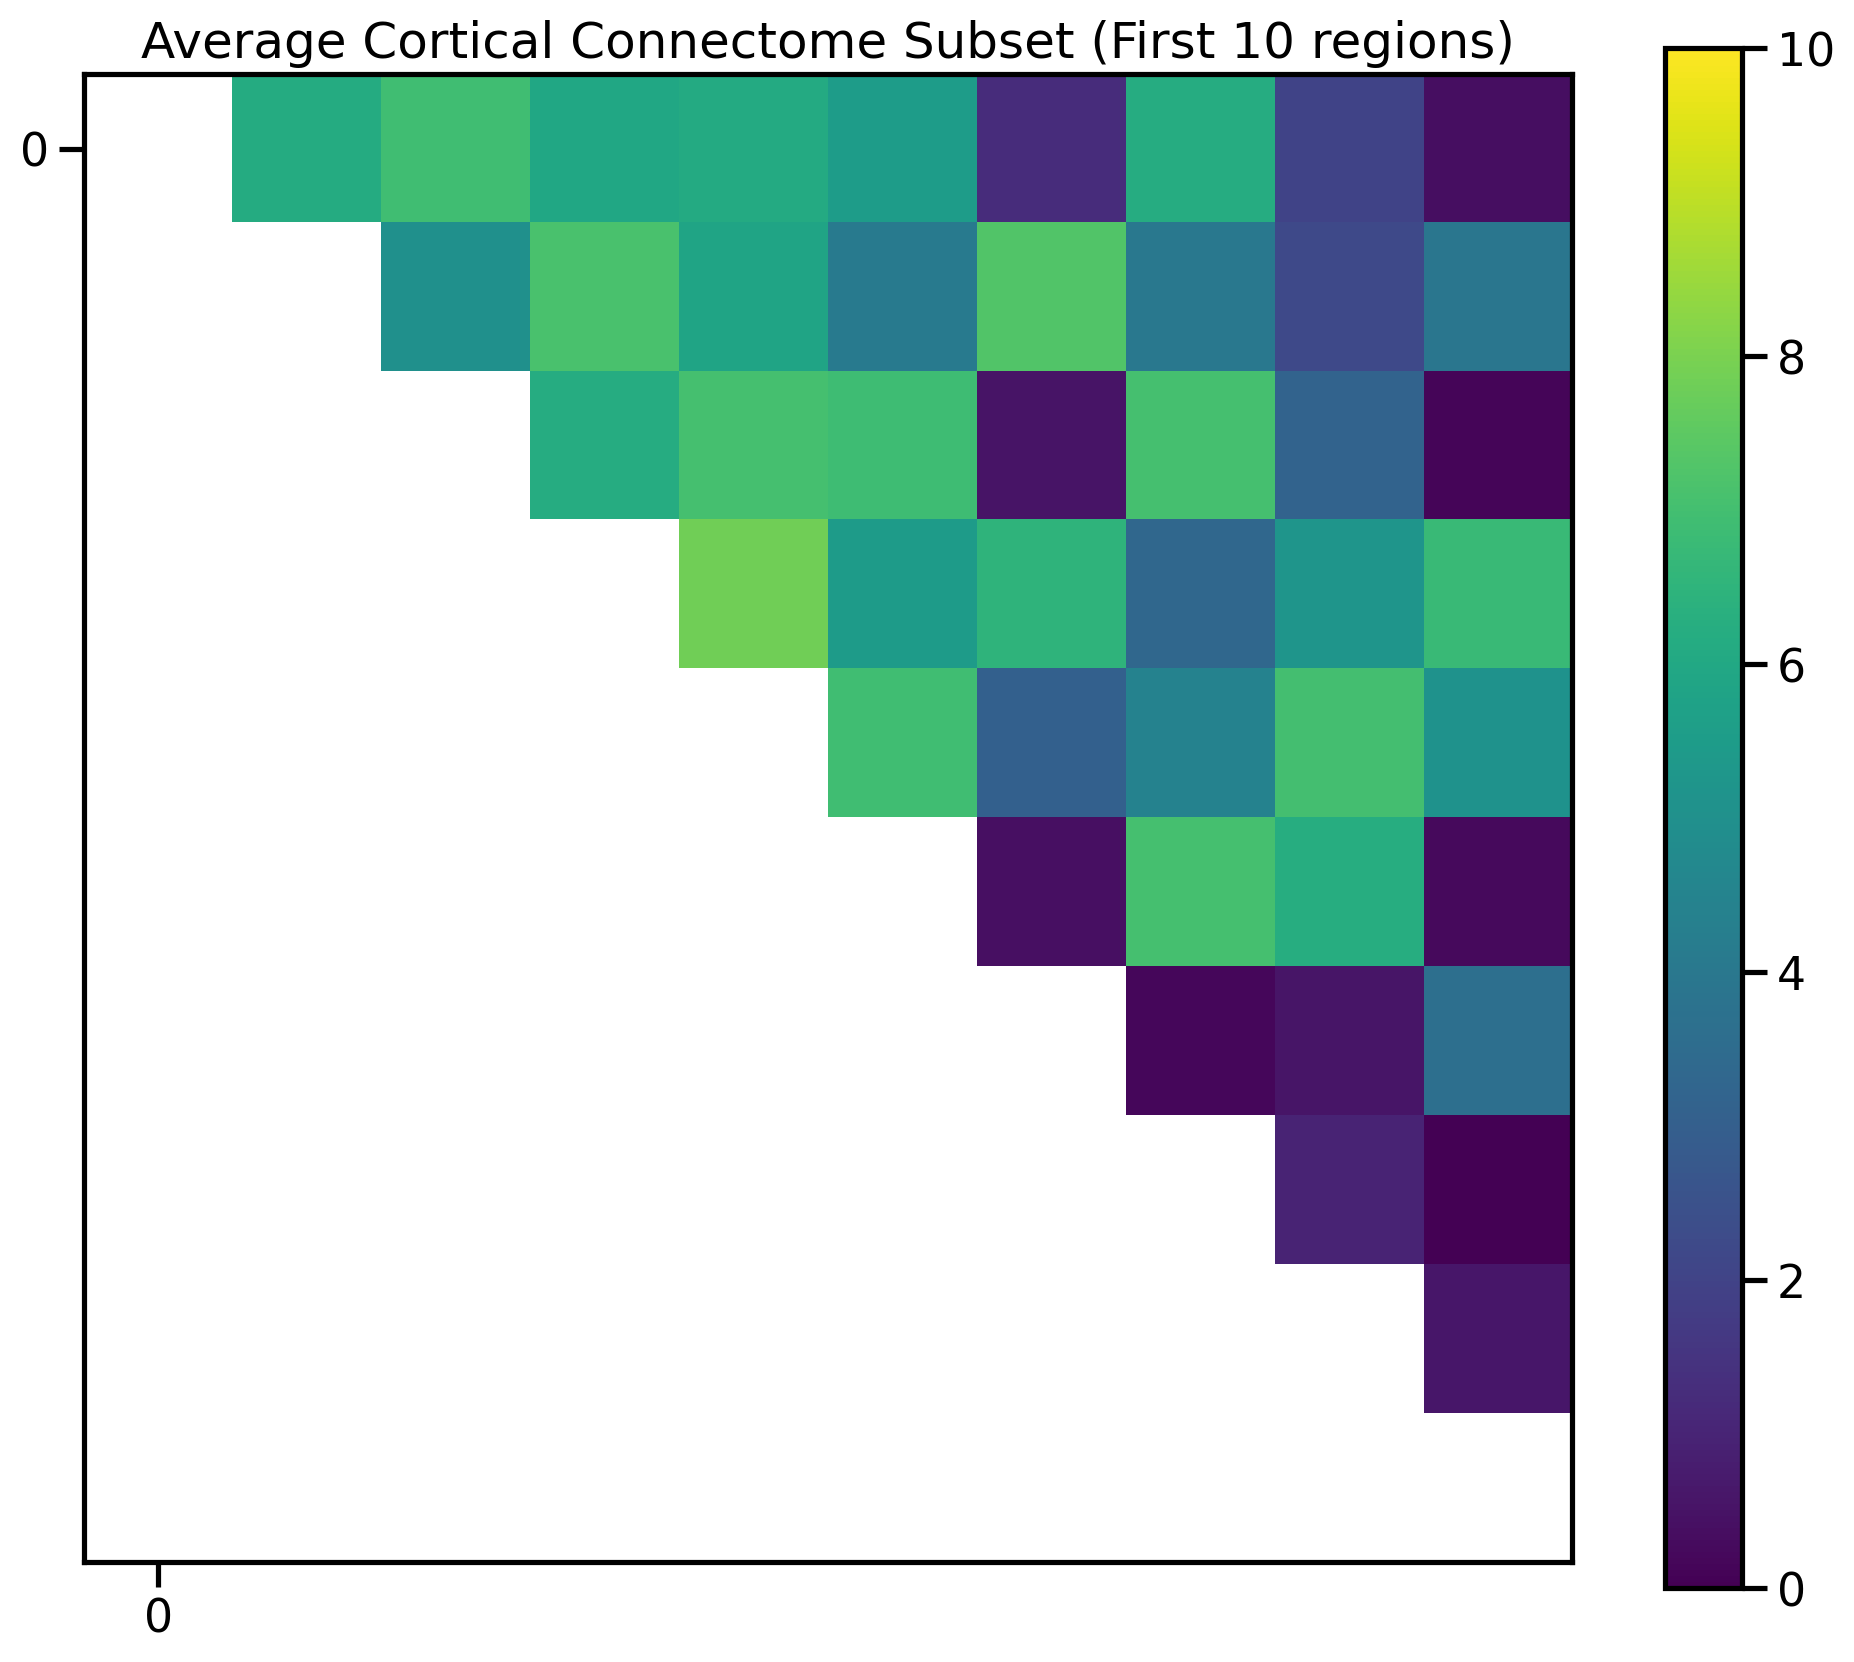

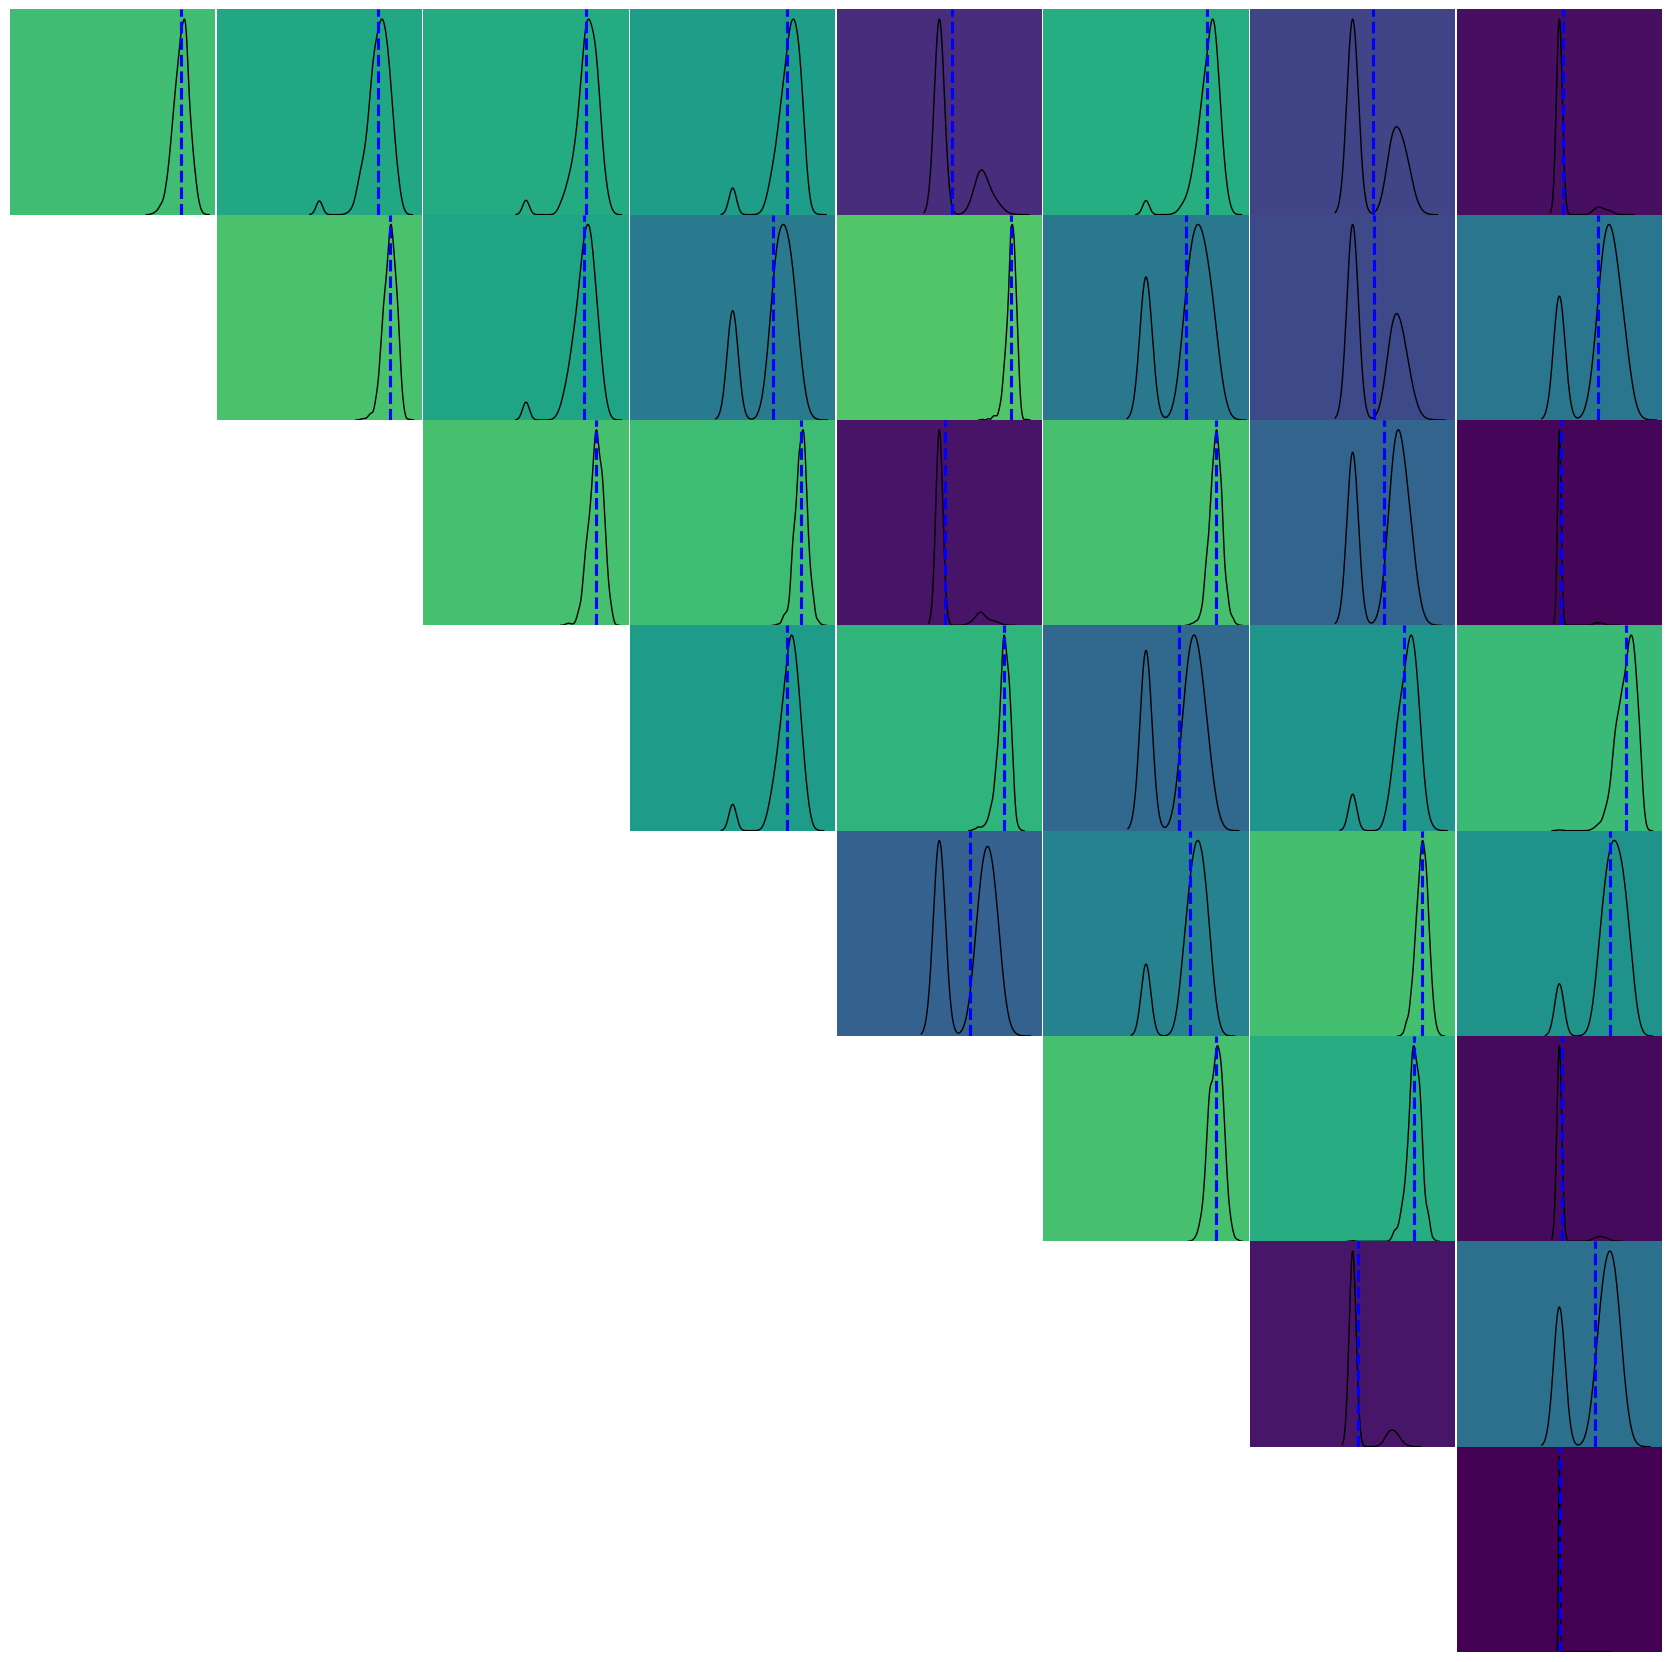

In [19]:
plot_edge_distributions(S456_connectomes, 10, HCP1200_S456_connectome_mu)

### Variance

In [26]:
def analyze_connectome_variance(connectomes, avg_connectome, n_regions=None, percentile=20):
    """
    Analyze and plot variance patterns in connectome data.
    
    Args:
        connectomes (list): List of individual subject connectome matrices
        avg_connectome (np.ndarray): Population average connectome matrix
        n_regions (int, optional): Number of regions to subset. If None, use full matrices
        percentile (float): Percentile cutoff for low variance connections (e.g. 20 means keep lowest 20%)
    """
    # Subset matrices if n_regions specified
    if n_regions is not None:
        connectomes = [conn[:n_regions, :n_regions] for conn in connectomes]
        avg_connectome = avg_connectome[:n_regions, :n_regions]
    
    # Convert to array and calculate variance
    connectome_array = np.array(connectomes)
    variance_matrix = np.nanvar(connectome_array, axis=0)
    
    # Plot variance matrix
    plt.figure(figsize=(12, 10), dpi=200)
    plt.imshow(variance_matrix, cmap='Reds', vmin=0, vmax=10)
    plt.colorbar(label='Variance')
    roi_str = f"{variance_matrix.shape[0]} ROIs"
    plt.title(f'Variance of Connections Across Subjects ({roi_str})')
    plt.show()

    # Calculate variance threshold based on percentile
    var_threshold = np.nanpercentile(variance_matrix, percentile)
    
    # Create and plot masked connectome
    low_var_mask = variance_matrix < var_threshold
    masked_connectome = avg_connectome.copy()
    masked_connectome[~low_var_mask] = np.nan

    # Plot full average connectome
    plt.figure(figsize=(12, 10), dpi=200)
    plt.imshow(avg_connectome, cmap='viridis')
    plt.colorbar(label='Correlation')
    plt.title(f'Average UKBB Cortical Connectome ({roi_str}, rsFC)')
    plt.show()
    
    # Plot masked connectome
    plt.figure(figsize=(12, 10), dpi=200)
    plt.imshow(masked_connectome, cmap='viridis')
    plt.colorbar(label='Correlation')
    plt.title(f'Population Average Connectome\n(Only Showing Lowest {percentile}% Variance Connections)')
    plt.show()

    # Calculate edge distribution statistics
    total_elements = masked_connectome.size
    nan_elements = np.isnan(masked_connectome).sum()
    valid_elements = total_elements - nan_elements

    # Get valid (non-NaN) elements
    valid_values = masked_connectome[~np.isnan(masked_connectome)]

    # Count edges in different ranges
    strong_pos = np.sum(valid_values > 0.2)
    weak = np.sum((valid_values >= -0.2) & (valid_values <= 0.2))
    strong_neg = np.sum(valid_values < -0.2)
    
    print(f"Low variance connections: {valid_elements} out of {total_elements} possible ({(valid_elements/total_elements*100):.2f}%)")
    print(f"\nEdge type distribution:")
    print(f"Positive (>0): {np.sum(valid_values > 0)} edges")
    print(f"  {np.sum(valid_values > 0)/valid_elements*100:.1f}% of low variance edges")
    print(f"  {np.sum(valid_values > 0)/total_elements*100:.1f}% of all possible edges")
    print(f"Zero (=0): {np.sum(valid_values == 0)} edges")
    print(f"  {np.sum(valid_values == 0)/valid_elements*100:.1f}% of low variance edges") 
    print(f"  {np.sum(valid_values == 0)/total_elements*100:.1f}% of all possible edges")

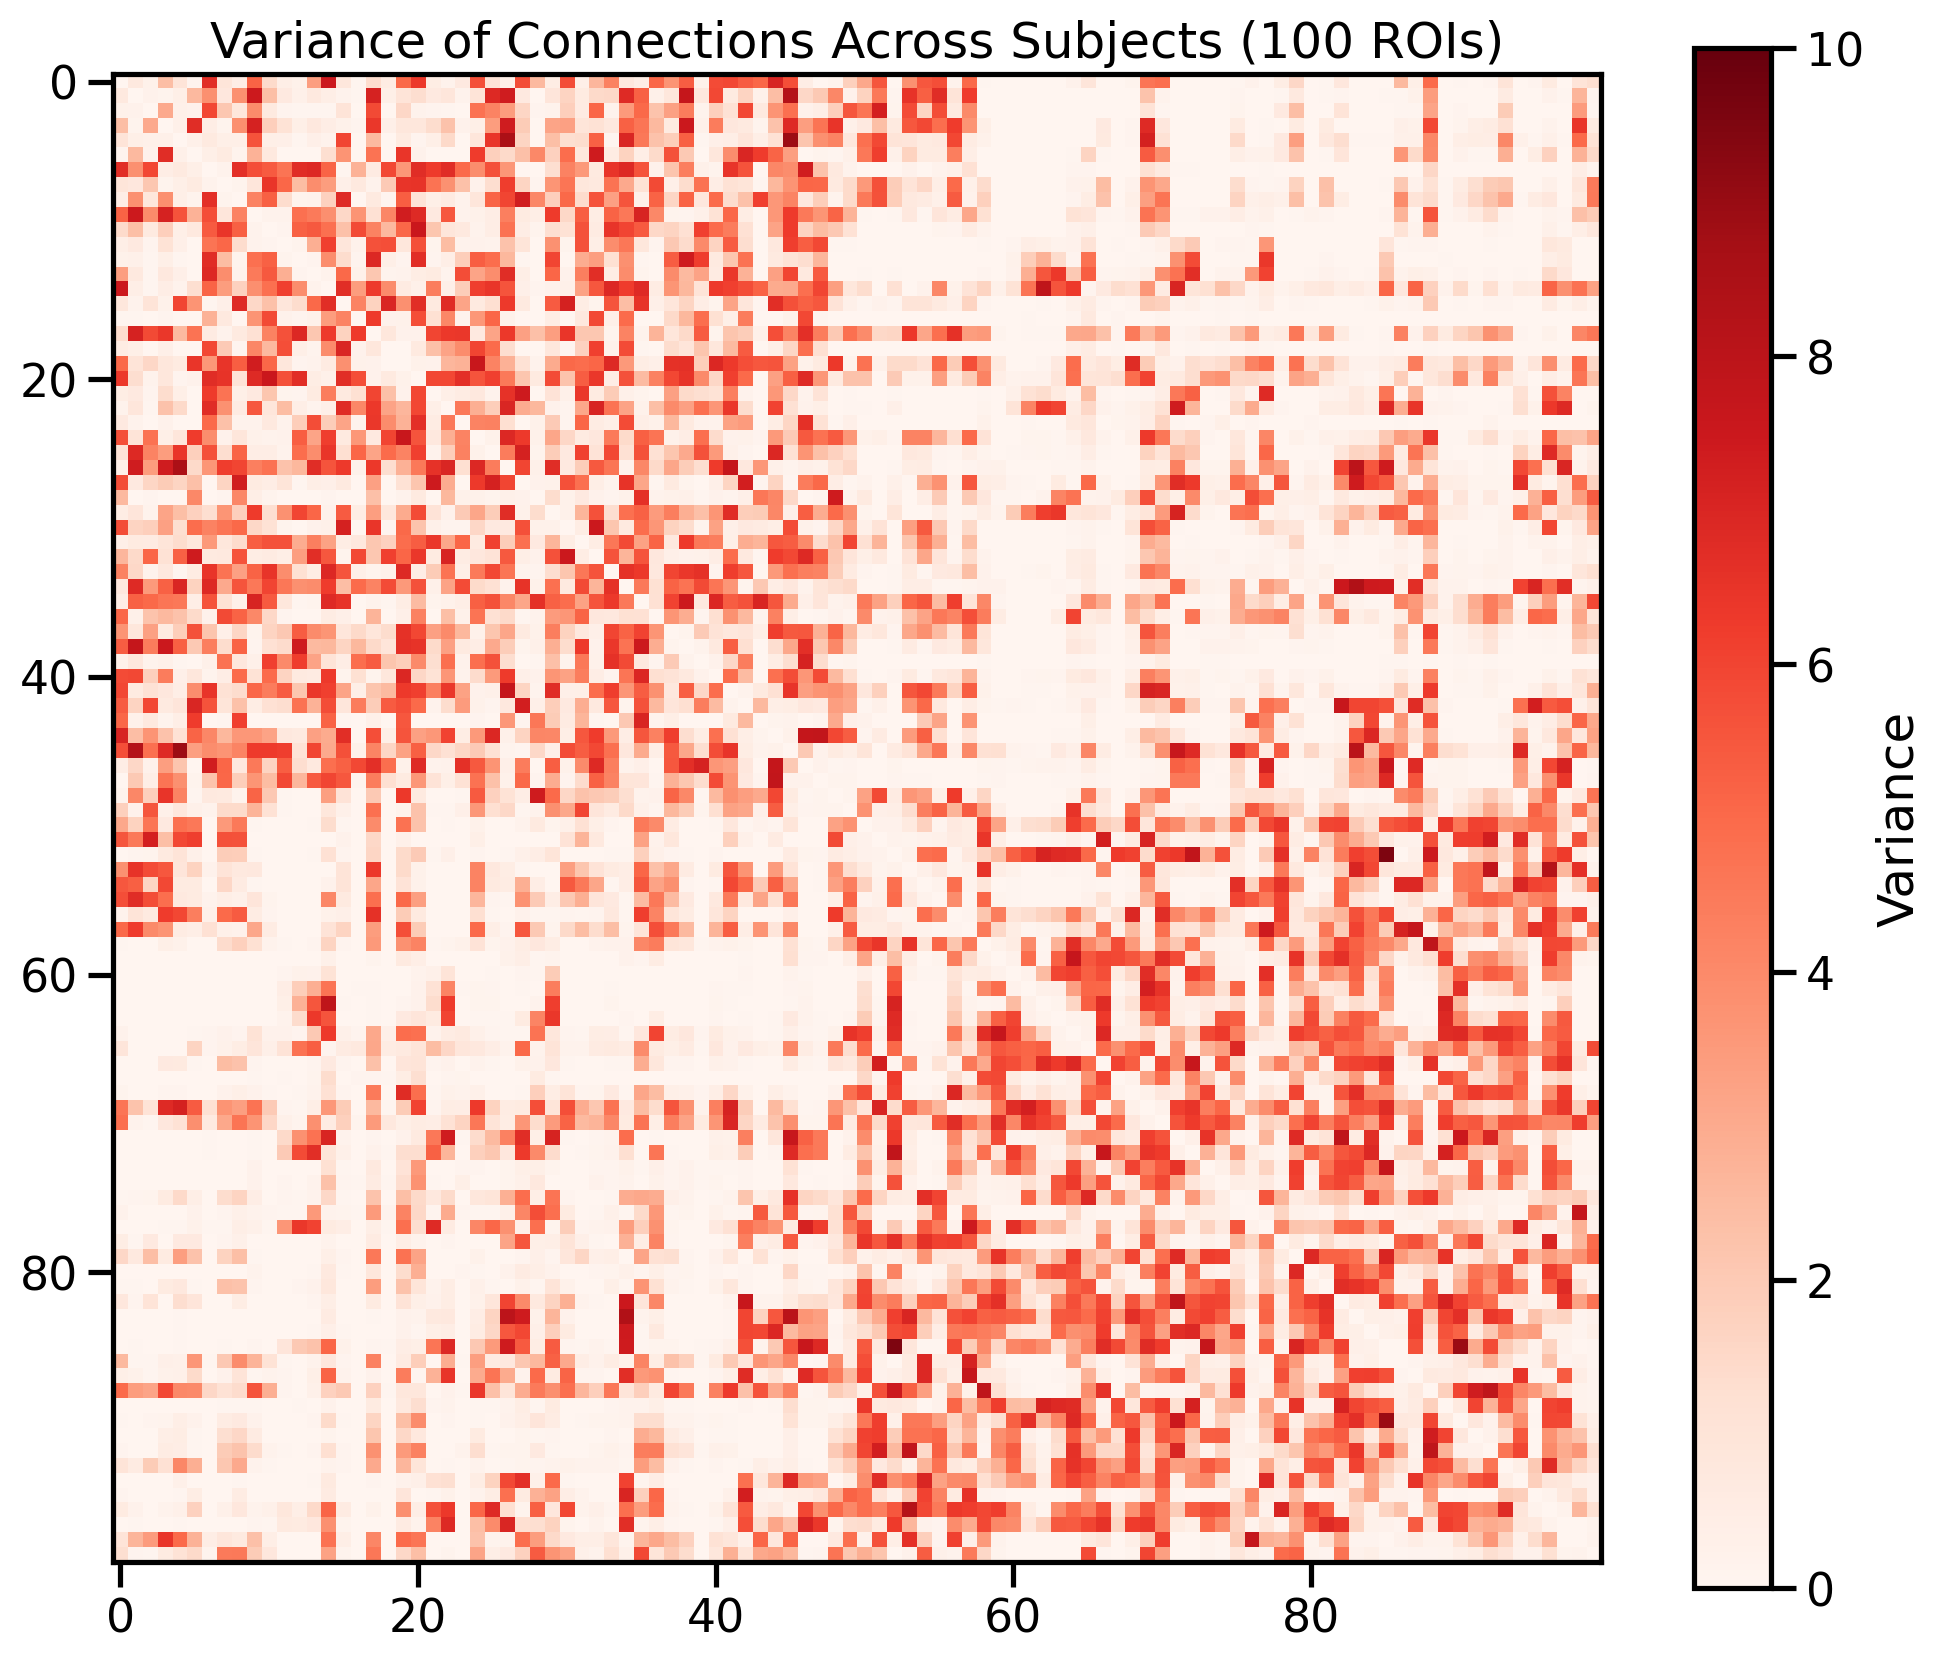

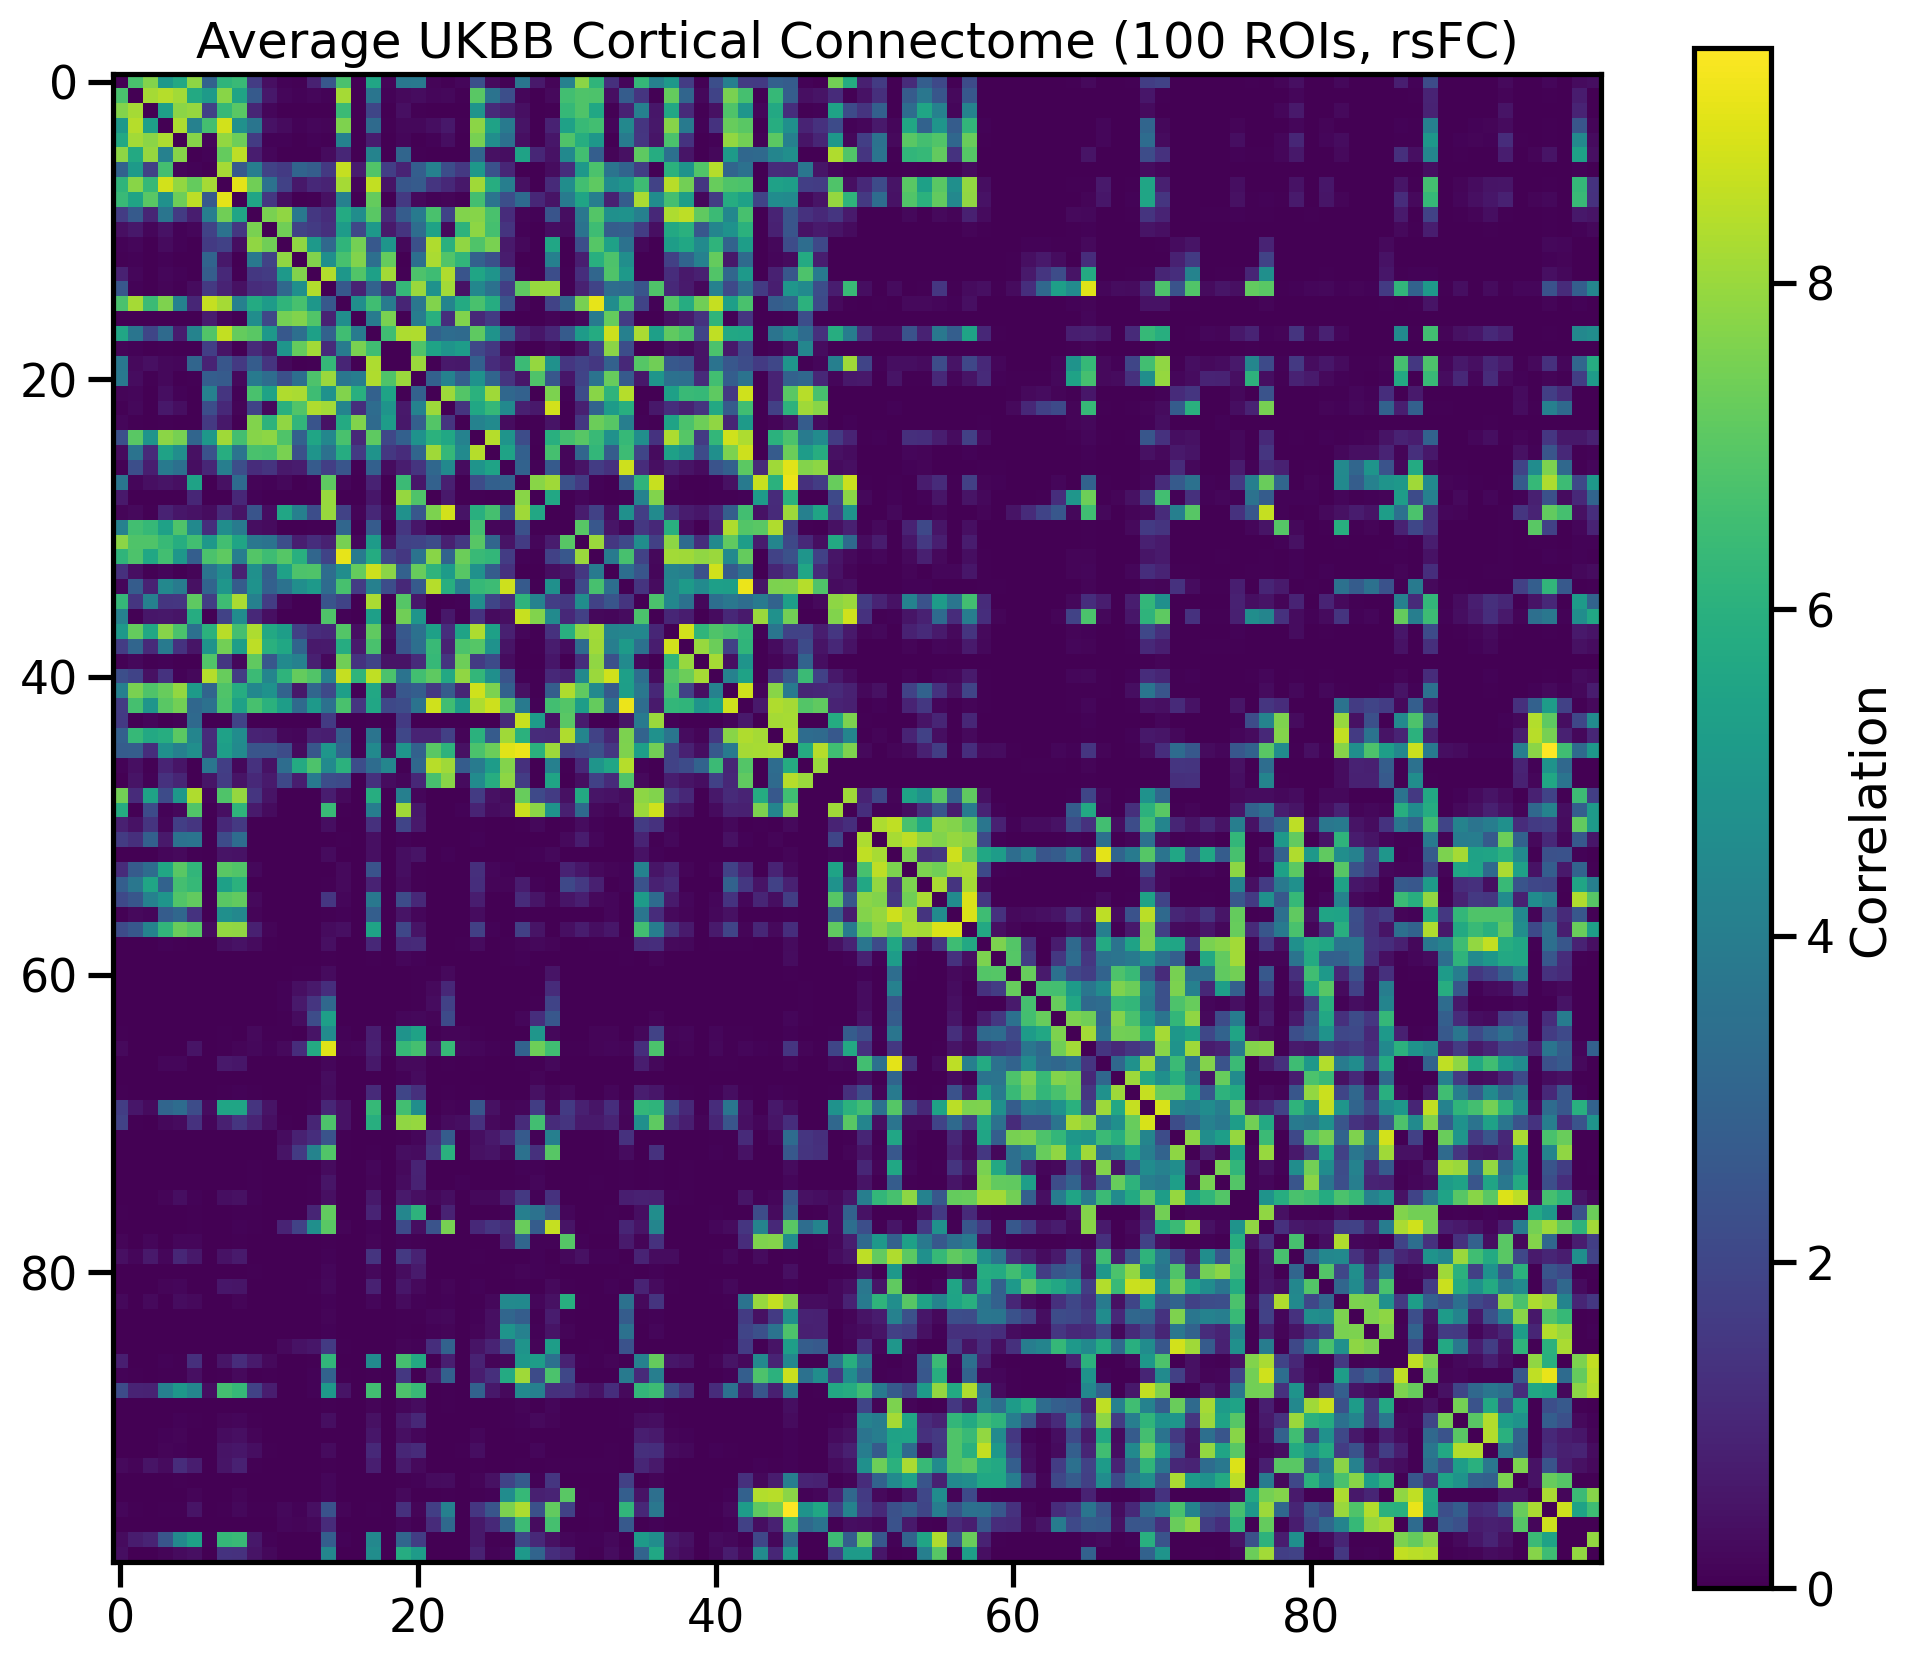

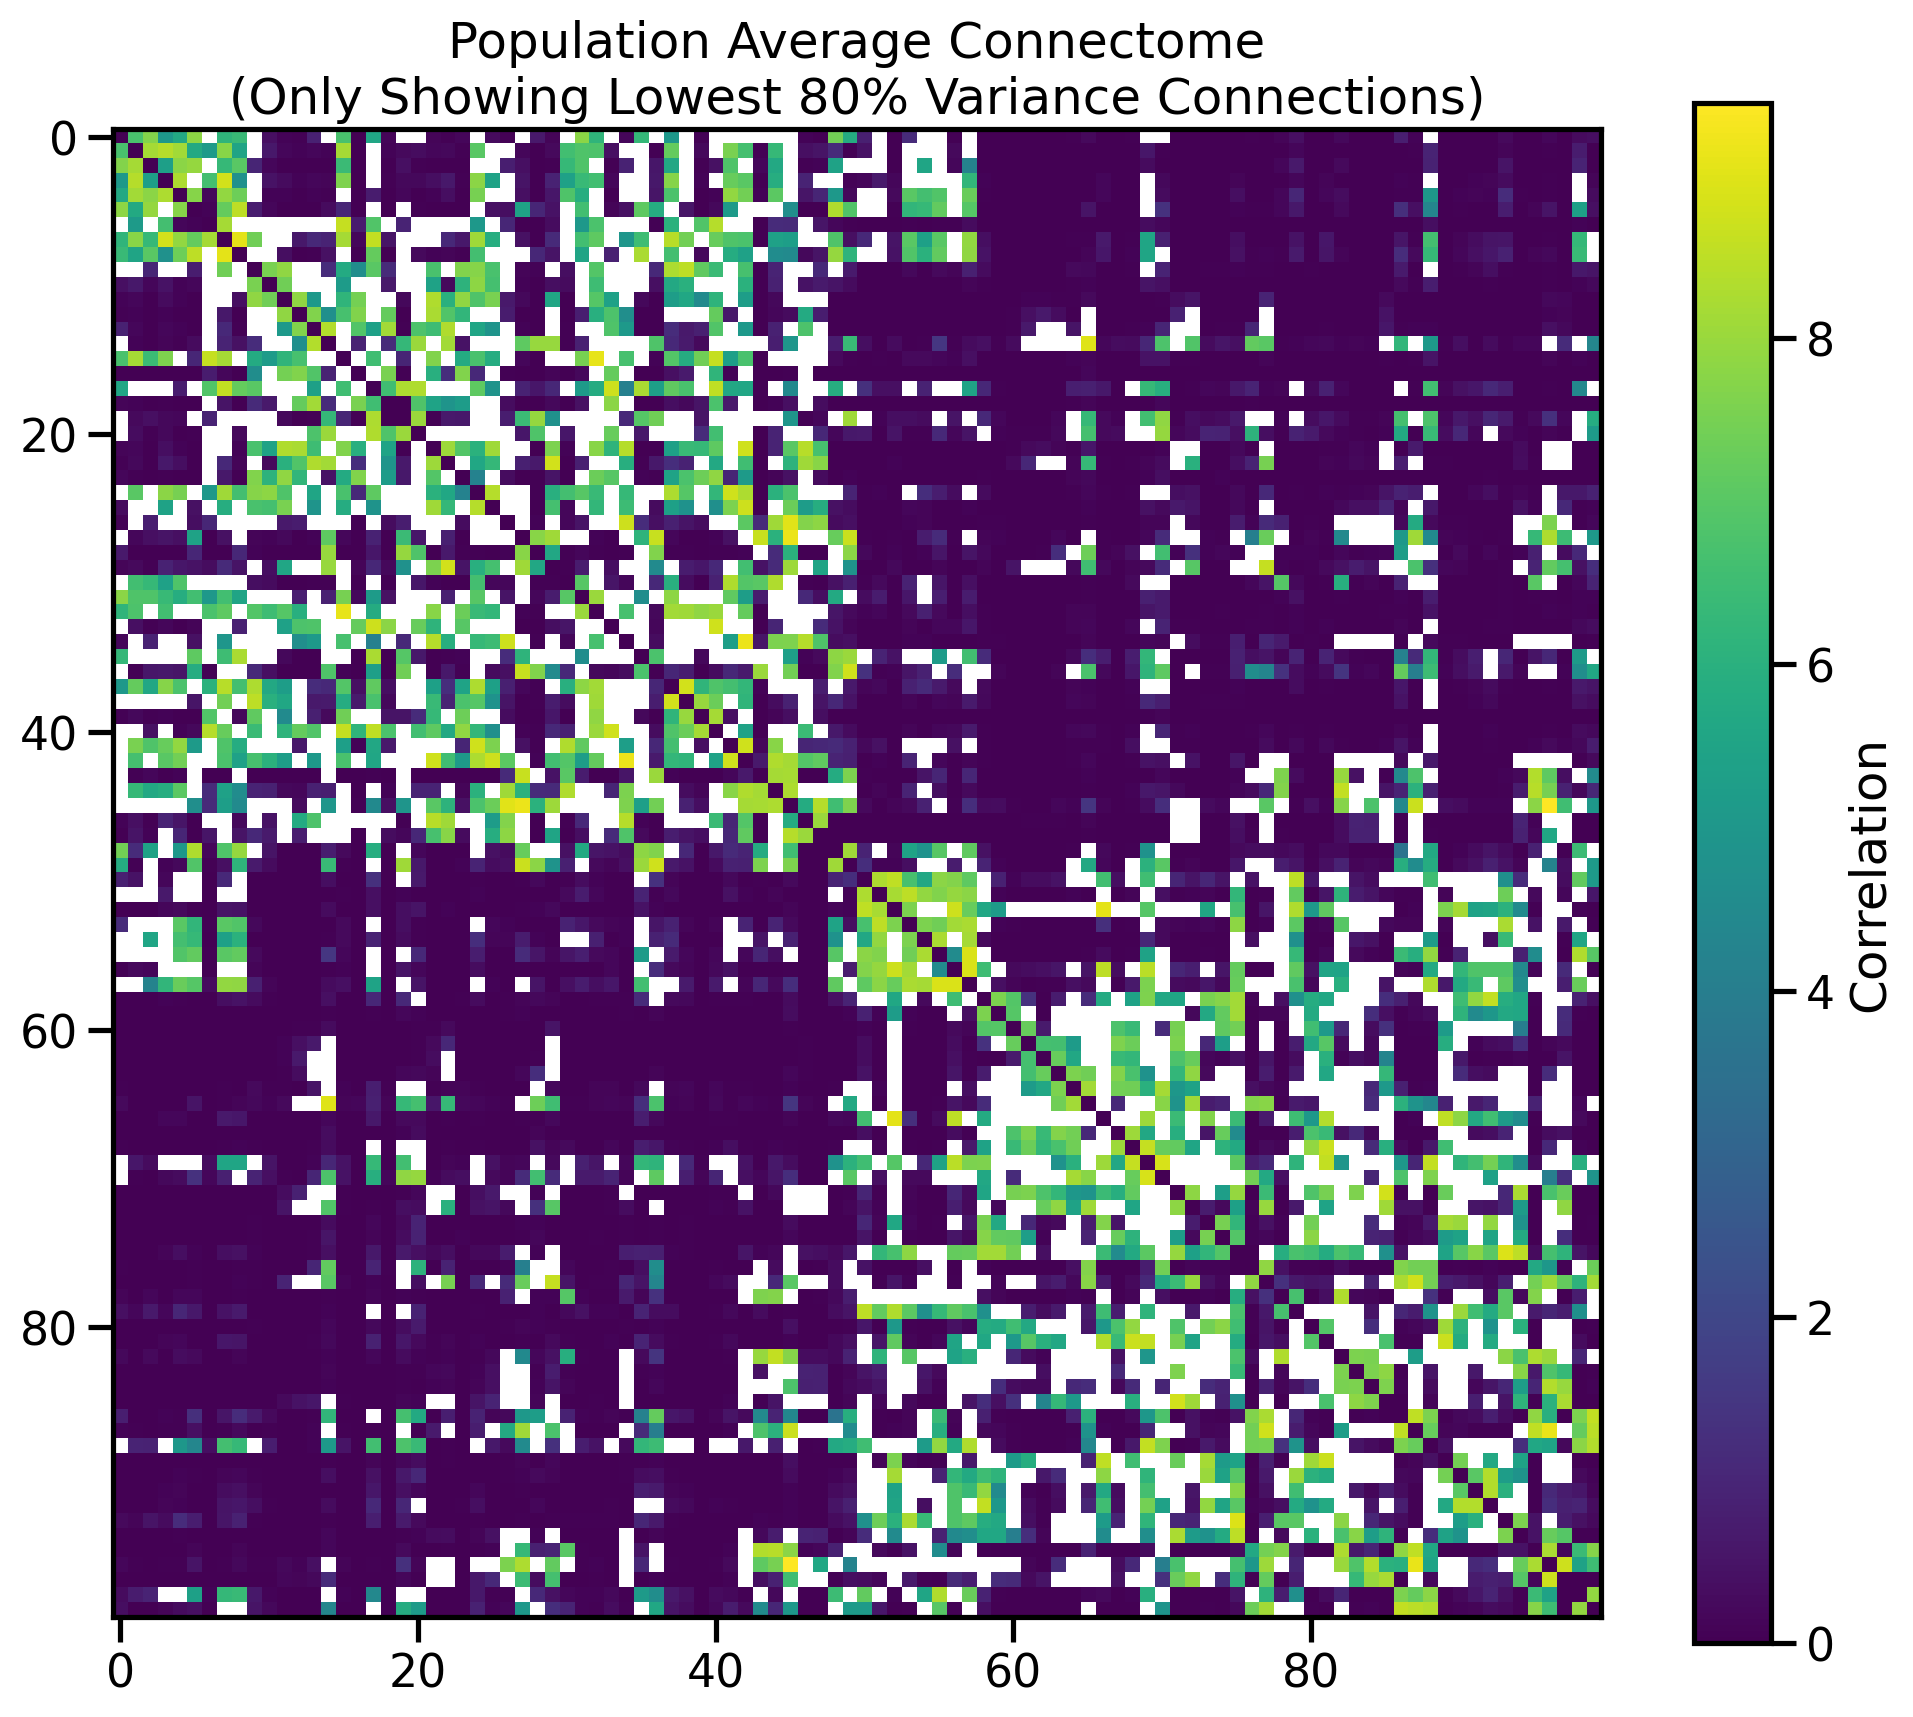

Low variance connections: 8000 out of 10000 possible (80.00%)

Edge type distribution:
Positive (>0): 6790 edges
  84.9% of low variance edges
  67.9% of all possible edges
Zero (=0): 1210 edges
  15.1% of low variance edges
  12.1% of all possible edges


In [29]:
# Analyze full connectome
analyze_connectome_variance(S156_connectomes, HCP1200_S156_connectome_mu, n_regions=100, percentile=80)


In [28]:
analyze_connectome_variance(S456_connectomes, UKBB_S456_connectome_mu, n_regions=456, percentile=25)

NameError: name 'UKBB_S456_connectome_mu' is not defined

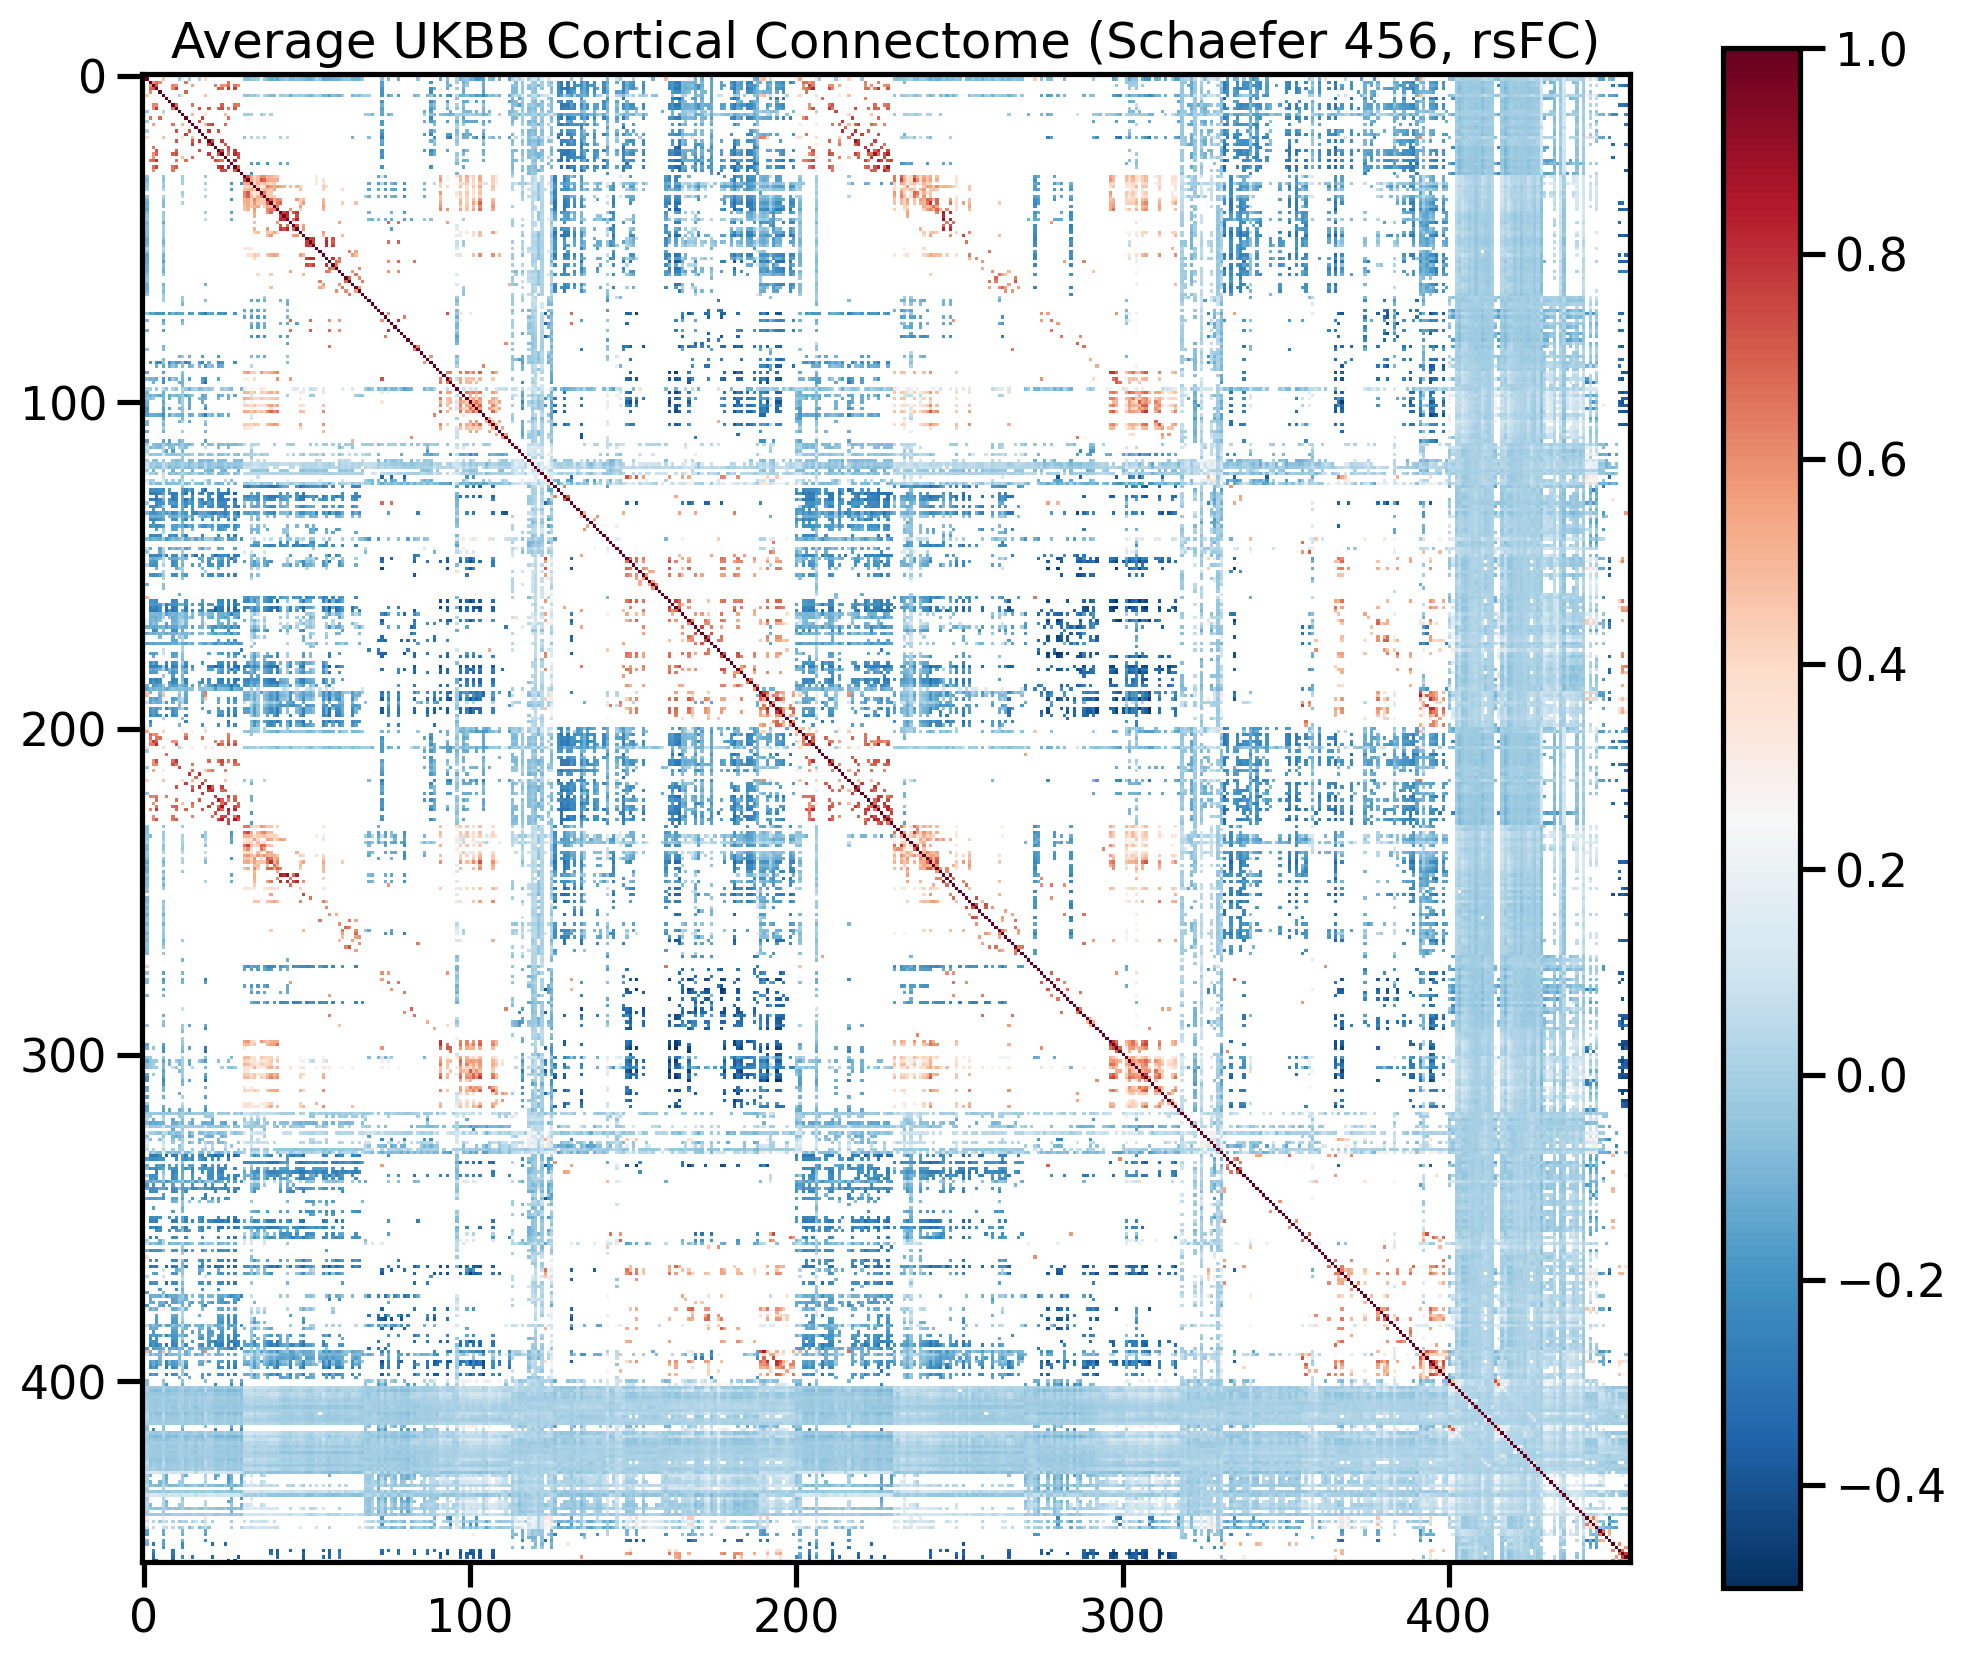

Low variance connections: 65978 out of 207936 possible (31.73%)

Edge type distribution:
Strong positive (>0.2): 5574 edges
  8.4% of valid edges
  2.7% of all possible edges
Weak (-0.2 to 0.2): 53268 edges
  80.7% of valid edges
  25.6% of all possible edges
Strong negative (<-0.2): 7136 edges
  10.8% of valid edges
  3.4% of all possible edges


In [62]:
avg_connectome = UKBB_S456_connectome_all

# Convert to array and calculate variance
connectome_array = np.array(all_S456_connectomes)
variance_matrix = np.nanvar(connectome_array, axis=0)

var_threshold=0.05

# Create and plot masked connectome
low_var_mask = variance_matrix < var_threshold
masked_connectome = avg_connectome.copy()
masked_connectome[~low_var_mask] = np.nan

S456_lowvar_avg_connectome = masked_connectome



plt.figure(figsize=(12, 10), dpi=200)
plt.imshow(S456_lowvar_avg_connectome, cmap='RdBu_r')
plt.colorbar() 
plt.title('Average UKBB Cortical Connectome (Schaefer 456, rsFC)')
plt.show()

# Calculate sparsity and edge distribution statistics
total_elements = S456_lowvar_avg_connectome.size
nan_elements = np.isnan(S456_lowvar_avg_connectome).sum()
valid_elements = total_elements - nan_elements

sparsity = nan_elements / total_elements * 100

# Get valid (non-NaN) elements
valid_values = S456_lowvar_avg_connectome[~np.isnan(S456_lowvar_avg_connectome)]

# Count edges in different ranges
strong_pos = np.sum(valid_values > 0.2)
weak = np.sum((valid_values >= -0.2) & (valid_values <= 0.2))
strong_neg = np.sum(valid_values < -0.2)

print(f"Low variance connections: {valid_elements} out of {total_elements} possible ({(valid_elements/total_elements*100):.2f}%)")
print(f"\nEdge type distribution:")
print(f"Strong positive (>0.2): {strong_pos} edges")
print(f"  {strong_pos/valid_elements*100:.1f}% of valid edges")
print(f"  {strong_pos/total_elements*100:.1f}% of all possible edges")
print(f"Weak (-0.2 to 0.2): {weak} edges") 
print(f"  {weak/valid_elements*100:.1f}% of valid edges")
print(f"  {weak/total_elements*100:.1f}% of all possible edges")
print(f"Strong negative (<-0.2): {strong_neg} edges")
print(f"  {strong_neg/valid_elements*100:.1f}% of valid edges")
print(f"  {strong_neg/total_elements*100:.1f}% of all possible edges")